# Proyección con MEDGE en python

El Modelo de Proyección Trimestral (MPT) del BCRP es un modelo semiestructural basado en el marco neokeynesiano, diseñado para el análisis de una economía pequeña y abierta. Este modelo es útil para:

* Proyectar la evolución futura de la economía: Permite generar escenarios y pronósticos sobre las principales variables macroeconómicas.
* Analizar la coyuntura económica reciente: Facilita la evaluación del impacto de diversos eventos y políticas en la economía.

La versión que se estudiará en este curso, denominada "MPT de bolsillo", es una simplificación del modelo completo. A pesar de su simplificación, conserva los principales canales de transmisión de choques y de la política monetaria, lo que permite comprender los mecanismos fundamentales que operan en la economía peruana.

**Revisar**: Aguirre y otros (2022), Winkelried (2013), Vega y otros (2009).

En esta sesión nos enfocaremos en dos de las ecuaciones principales del modelo.

## Curva de Phillips

$$\pi_t^{sae} = b_m \Pi_t^{m} + (1 - b_m) \left[b_{sae} \pi_{t-1}^{sae} + (1 - b_{sae}) \Pi_{t}^{e}\right] + b_y \left[c_y y_t + (1 - c_y) y_{t-1}\right] + \sigma_{\varepsilon^{\pi,sae}} \varepsilon_t^{sae} $$

## Regla de Taylor

$$ i_t = \phi  i_{t-1} + (1 - \phi) \left( i^{n}_t + f_p D4pdev_t + f_y \left( c_{fy} y + (1 - c_{fy}) y_{t-1} \right) \right) + \sigma_{\varepsilon^{i}} \varepsilon^{i}_t $$

**Tarea**: revisar el resto del MPT y sus canales de transmisión:
1. Impacto del sector externo (inflación, tasa externa, brecha externa y TI)
2. Impacto de choques fiscales
3. Impacto de la confianza empresarial/expectativas
4. Choques de costos

En general, la estimación de un modelo de equilibrio general (como un semiestructural o un DSGE), implica tres pasos:
1. Plantear el modelo teórico, i.e., canales de transmisión y relación entre variables a estudiar: Esto nos da la **forma estructural** el modelo
$$\mathbf{f}_{0}+\mathbf{f}_{y'}\mathrm{E}_t\mathbf{y}_{t+1}+\mathbf{f}_{y}\mathbf{y}_{t}+\mathbf{f}_{y^{\ell}}\mathbf{y}_{t-1}+\mathbf{f}_{u}\mathbf{u}_{t}=0$$
2. Resolver el modelo, se deben cuplir las condiciones de BK: De esto se obtiene la **forma reducida** el modelo
$$\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
3. Reescribir el modelo como una representación de espacio estado:
$$\text{Medidas}:\quad\mathbf{z}_{t} = \mathbf{H}\mathbf{y}_{t}$$
$$\text{Estados}:\quad\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
4. Con los datos, $\mathbf{z}_{t}$, el FK nos da la verosimilitud, si además se formulan los prior para los coeficientes, se puede etimar la posterior
5. Repetir 1-4 hasta maximizar la posterior, y luego implementar MH para simular la posterior


El modelo de esta sesión ya ha sido estimado

## Librerias requeridas

Configuración inicial para modo de ejecución

In [119]:
flag_runlocal = False    # "False" para ejecutar en google colab

Las librerías a continuación han sido desarrolladas para estre curso. Éstas se encargan del procesamiento del modelo, la implementación numérica de la solución y calculos de productos asociados (IRF, KF y proyección), ademas del manejo de los datos.

In [120]:
import sys
import os

if flag_runlocal:
    # ---> Ejecución local
    pathPolMon = os.getcwd() + '/'

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/jamayat/CUECOPolMon.git
    pathPolMon = '/content/CUECOPolMon/'

sys.path.append(pathPolMon+'02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

fatal: destination path 'CUECOPolMon' already exists and is not an empty directory.
IPython console for SymPy 1.13.1 (Python 3.11.11-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.1/



Librería externas complementarias

In [121]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

## Procesamiento el modelo

La función ```process_file3``` lee el modelo y construye las funciones necesarias para computar la solución:

**ver modelo**: 04_Modelo/MPTBolsillo.txt

En ese archivo se declaran variables endógenas, exógenas y observables (recordar filtro de Kalman).


In [122]:
Mod = DPP.process_file3(pathPolMon+'04_Modelo/MPTBolsillo.txt')

El objeto de salida ```Mod``` es un diccionario con información sobre el modelo y funciones vinculadas a la forma estructural del modelo

In [123]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm'])

### Solución del modelo

A continuación se resuelve el modelo y se verifican las condiciones de estabilidad.
Es necesario incluir una calibración de coeficientes y un estado estacionario (**ver**: 04_Modelo/Cal_MPTBolsillo.txt)

**Nota**: En caso deseen hacer cambios en coeficientes, estos deben ocurrir en esta etapa

In [124]:
Mod = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

Ahora ```Mod``` contiene una llave adiciona: 'Solution'

In [125]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm', 'Solution'])

### Estudio de las FIR

La función ```getIRF``` generar todos los FIRs

In [126]:
Horizon=20
IRF = DLM.getIRF(Mod,Horizon)

```IRF``` es un diccionario cuyas "keys" son los choques, dentro de cada "key" se encuentran las respuestas de todas las endogenas ante ese choques.

El impulso (o choque) esta fijado en 1. Debido a que en el modelo se multiplica a los choques por su desviación estándar, entonces las respuestas son ante choques de 1 desviación estándar.

In [127]:
IRF.keys()

dict_keys(['res_DY_eq', 'res_Dpae', 'res_Dpsae', 'res_ED4p', 'res_Dpm', 'res_Meta', 'res_i', 'res_ieq', 'res_imn', 'res_zmn', 'res_ime', 'res_zme', 'res_Ds', 'res_ED4s', 'res_x', 'res_x_eq', 'res_DQ_eq', 'res_y', 'res_EDy', 'res_t', 'res_g', 'res_DTI', 'res_tau', 'res_DYs_eq', 'res_Dps', 'res_Dpms', 'res_iext', 'res_ys', 'res_ieqs', 'res_z'])

Por ejemplo, a continuación se pueden apreciar las respuestas ante un choque a la inflación AE

In [128]:
IRF['res_Dpae'].head(5)

DY_eq  DYs_eq        Ds         y   ys      Dpae        Dp    Dp(-2)  \
0    0.0     0.0 -0.146240 -0.009528  0.0  3.956719  1.783490  0.000000   
1    0.0     0.0 -0.205642 -0.010296  0.0 -0.042675  0.020465  0.000000   
2    0.0     0.0 -0.236798  0.004243  0.0 -0.035848  0.040351  1.783490   
3    0.0     0.0 -0.243212  0.020689  0.0 -0.028240  0.052125  0.020465   
4    0.0     0.0 -0.229679  0.033654  0.0 -0.020052  0.058398  0.040351   

     Dp(-1)       D4p  ...   D4s(+1)    x        DQ     DQ_eq  D4ps  D4ps(+3)  \
0  0.000000  0.445872  ... -0.087971  0.0 -1.929730 -0.354504   0.0       0.0   
1  1.783490  0.450989  ... -0.147170  0.0 -0.226107 -0.330917   0.0       0.0   
2  0.020465  0.461076  ... -0.207973  0.0 -0.277149 -0.321039   0.0       0.0   
3  0.040351  0.474108  ... -0.228833  0.0 -0.295337 -0.316318   0.0       0.0   
4  0.052125  0.042835  ... -0.228523  0.0 -0.288077 -0.311130   0.0       0.0   

   D4ps(+2)  D4ps(+1)   Rs  Rs_eq  
0       0.0       0.0  0.0    0.0  
1       0.0       0.0  0.0    0.0  
2       0.0       0.0  0.0    0.0  
3       0.0       0.0  0.0    0.0  
4       0.0       0.0  0.0    0.0  

[5 rows x 74 columns]

Ejemplo para visualizar las respuestas

$ Dpsae \rightarrow (ED4p, Dp) \rightarrow i$

$ i \rightarrow y \rightarrow (ED4p, Dpsae) \rightarrow Dp$

Text(0.5, 1.0, 'Respuestas de la TPM')

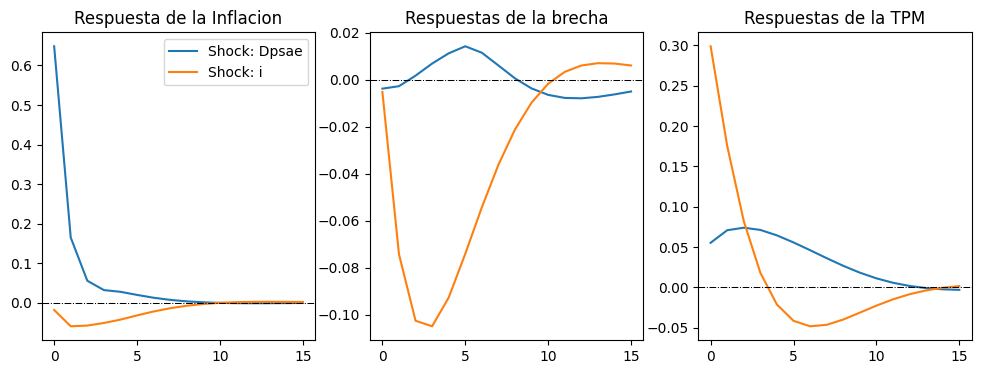

In [129]:
TP = 16   # Horizon to plot (<=Horizon)

shockslist = ['res_Dpsae','res_i']
varslist = ['Dp','y','i']

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[0]][:TP], linestyle='-',label="Shock: Dpsae")
axs[0].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[0]][:TP], linestyle='-',label="Shock: i")
axs[0].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[0].set_title("Respuesta de la Inflacion")
axs[0].legend(loc="best")

axs[1].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[1]][:TP], linestyle='-',label="Shock: Dpsae")
axs[1].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[1]][:TP], linestyle='-',label="Shock: i")
axs[1].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[1].set_title("Respuestas de la brecha")

axs[2].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[2]][:TP], linestyle='-',label="Shock: Dpsae")
axs[2].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[2]][:TP], linestyle='-',label="Shock: i")
axs[2].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[2].set_title("Respuestas de la TPM")

# Proyección

1. Se cargan los datos de variables observables. Estas se recaban de instituciones de estadísticas y se sintetizan para que sean insumidas por el modelo.

In [130]:
Describ, DBobs = HTS.ReadDB_excel(pathPolMon+'Tarea/DataTarea.xlsx', sheet='VarObs')

Para la presentación de resultados, recogemos las variables endógenas y exógenas del modelo

In [131]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

Visualización de las variables medibles

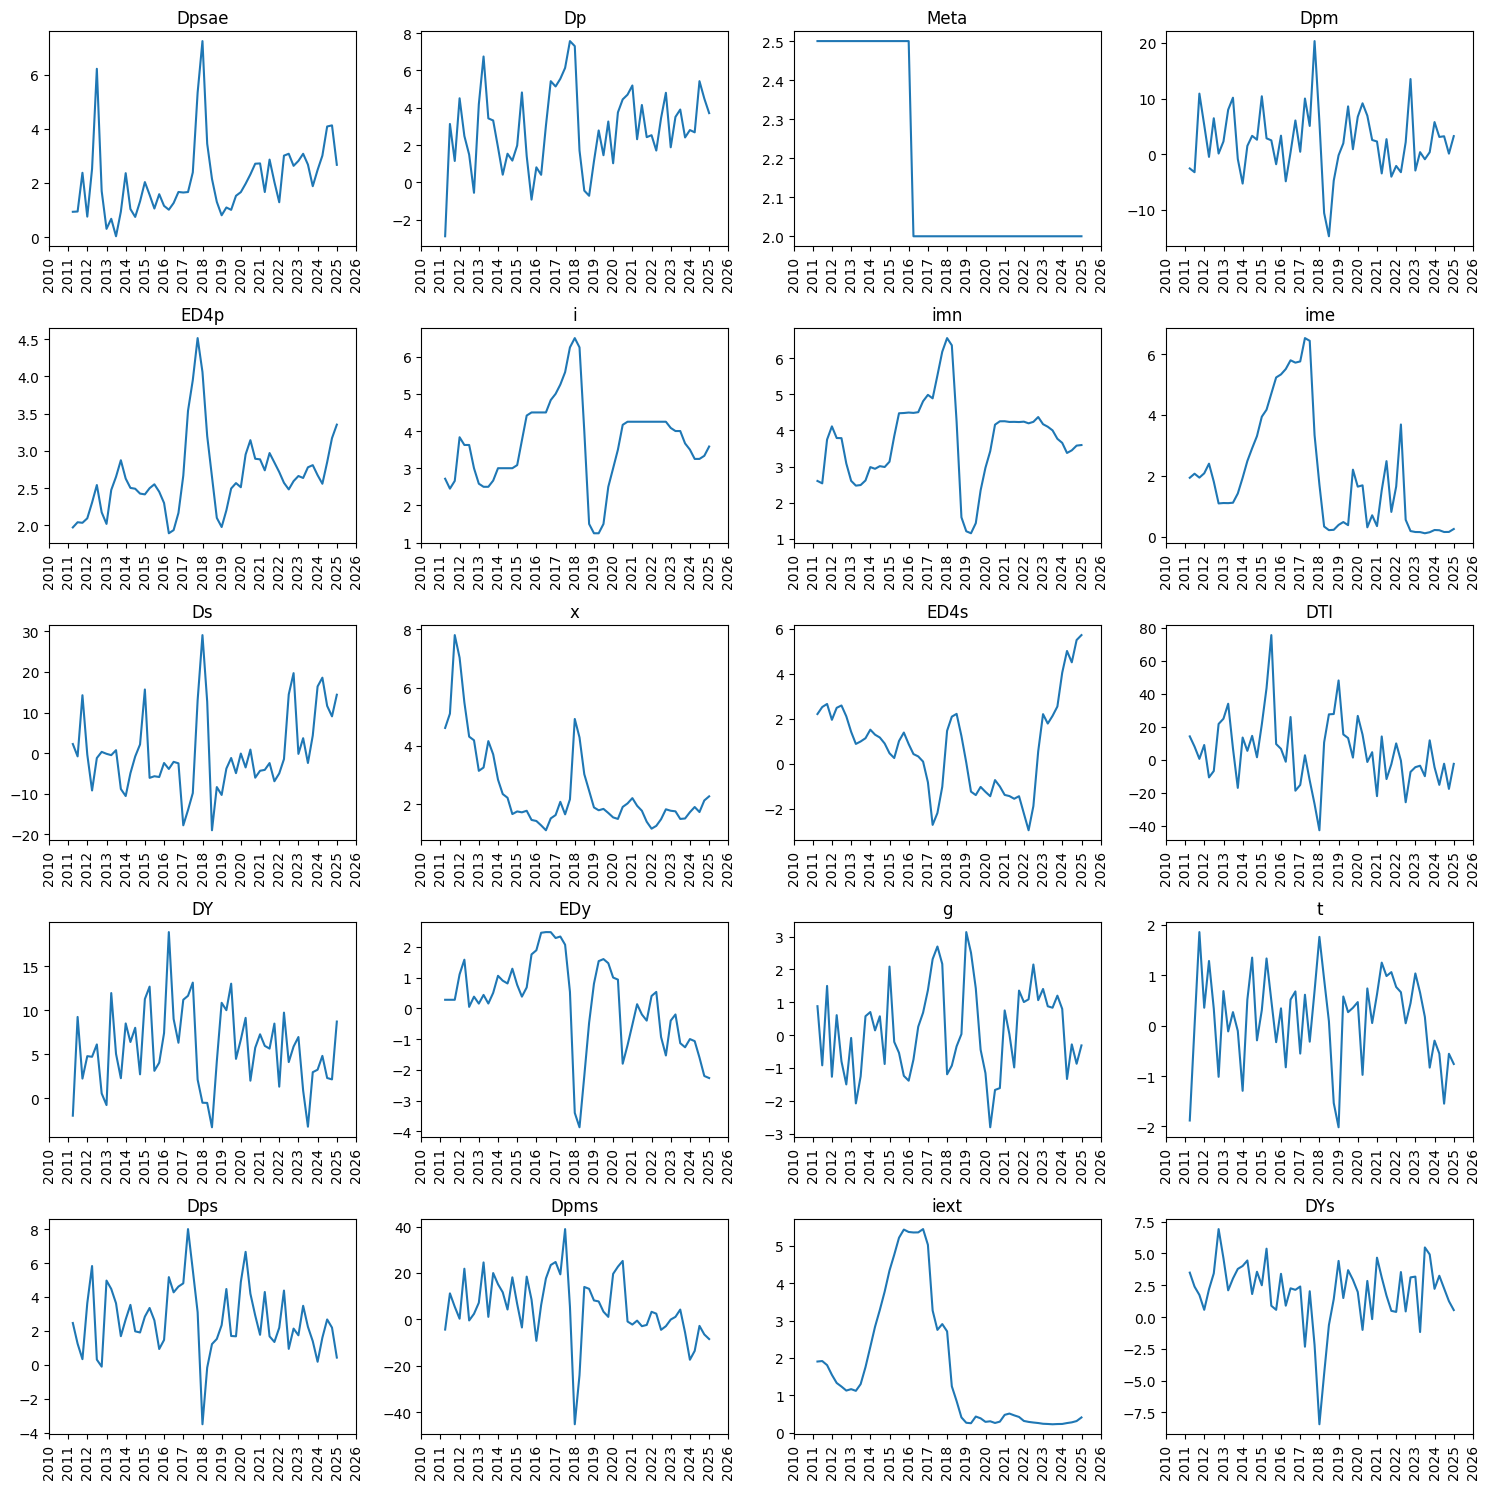

In [132]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

2. Con el filtro de Kalman se estiman las variables no observables, consistente con la estructura del MPT.

In [133]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False})
# DF_s:  smoothed
# DF_u:  updated
Data = DF_s
Data.tail(4)

DY_eq    DYs_eq         Ds         y        ys      Dpae  \
2024-03-31  3.741512  1.572541  18.601325 -0.372058 -0.424948  2.275660   
2024-06-30  3.837340  1.481059  11.631337 -0.749937 -0.232537  7.078403   
2024-09-30  3.975434  1.436834   9.053224 -1.201698 -0.279071  4.939607   
2024-12-31  4.061683  1.428075  14.390420 -0.034537 -0.498415  4.993248   

                  Dp    Dp(-2)    Dp(-1)       D4p  ...    D4s(+1)         x  \
2024-03-31  2.680545  2.406473  2.801772  2.947635  ...   9.533080  1.904598   
2024-06-30  5.422641  2.801772  2.680545  3.327858  ...  11.216721  1.731182   
2024-09-30  4.489321  2.680545  5.422641  3.848570  ...   9.583825  2.129473   
2024-12-31  3.708887  5.422641  4.489321  4.075349  ...   8.370837  2.270804   

                   DQ     DQ_eq      D4ps  D4ps(+3)  D4ps(+2)  D4ps(+1)  \
2024-03-31  17.521715  6.313536  1.353402  1.695702  1.302945  1.217756   
2024-06-30   8.882800  6.785505  1.462109  2.010292  1.979153  1.586919   
2024-09-30   6.758780  6.780595  1.662531  1.838380  2.084314  2.059953   
2024-12-31  11.108833  7.575748  1.724304  1.262829  1.399839  1.670102   

                  Rs     Rs_eq  
2024-03-31 -1.474856 -0.528716  
2024-06-30 -1.492735 -0.604802  
2024-09-30 -1.398074 -0.616680  
2024-12-31 -1.161649 -0.536551  

[4 rows x 74 columns]

<Axes: >

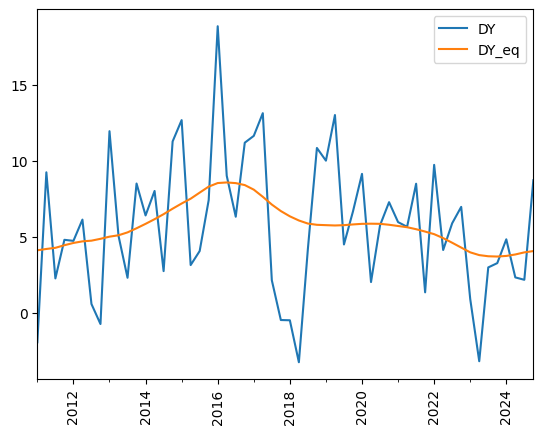

In [134]:
Data[['DY', 'DY_eq']].plot.line(rot = 90)

3. Ejemplos de proyección

**Proyección incondicional**

Se proyectarán 8 trimestres desde el último periodo de información 2024Q4.

La proyección es libre de condicionantes. En consecuencia, se observa la convergencia de la economía hacia su estado estacionario, tomando como punto de partida la situación inicial. Cabe destacar que ciertas variables presentan dependencia de múltiples rezagos.

In [135]:
FH = 8 # Horizonte de proyección (2 años)
StartingPeriod = '2025Q1'
FDB = DLM.DSGEforecast0(Mod,Data,FH,StartingPeriod)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


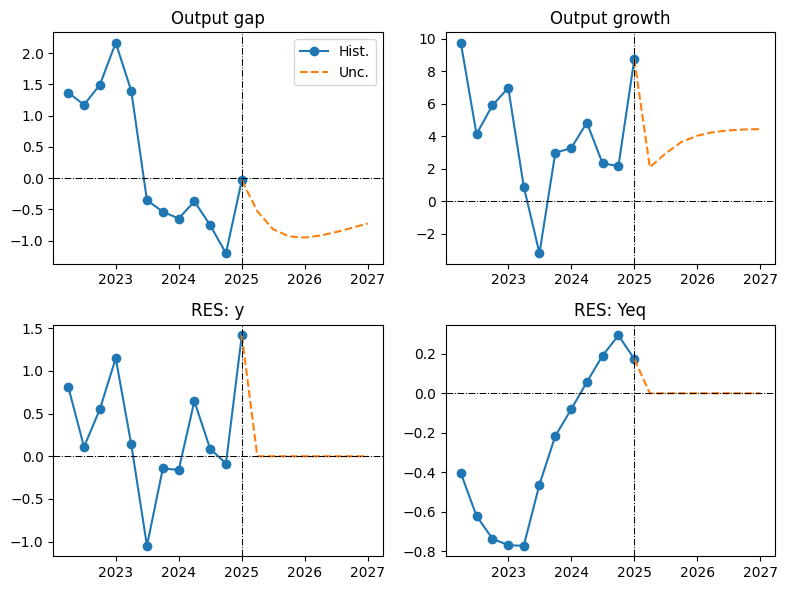

In [136]:
DBdict = {'Unc.': FDB}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

**Proyección condicionada**

Es posible incorporar al modelo proyecciones externas para variables tanto observables como no observables, actuando como condicionantes. El Modelo de Proyección Trimestral (MPT) ajustará sus resultados en función de estas trayectorias predefinidas (hardtuning). Las variables restantes se adaptarán a la información ingresada, siguiendo las relaciones establecidas por las ecuaciones y los canales de transmisión del modelo. Los choques (residuos) funcionarán como mecanismos de ajuste, absorbiendo las discrepancias entre las variables proyectadas externamente y las explicadas por el modelo.

Por ejemplo, se podría introducir una proyección externa sobre la evolución de la tasa de interés de la Reserva Federal (FED), aunque esta no esté modelada explícitamente (la parte externa representa una simplificación). Esta información, basada en juicio experto o modelos satélite, se incorpora como un dato exógeno.

En la presente sesión, se analizará el impacto de un choque positivo en la demanda, que impulsará la brecha del producto. Adicionalmente, se observará una reacción más pronunciada de la inflación subyacente.

Para este ejercicio, se proponen dos escenarios de análisis:
- **Escenario 1**: Tasa de interés libre. Este escenario permite examinar el efecto conjunto del choque y la reacción del banco central, siguiendo la regla de Taylor. Proporciona una estimación del comportamiento probable del banco central.
- **Escenario 2**: Tasa de interés fija. Este escenario evalúa el impacto del choque, asumiendo que el banco central mantiene la tasa de interés en el nivel del escenario base, sin reaccionar.

# Escenario base

In [137]:
UCond_base = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

In [138]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_base['UShock'])
print('Unanticipated Hardtunning')
print(UCond_base['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_base['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps  res_ys
2025-03-31      NaN     NaN
2025-06-30      NaN     NaN
2025-09-30      NaN     NaN
2025-12-31      NaN     NaN
2026-03-31      NaN     NaN
2026-06-30      NaN     NaN
2026-09-30      NaN     NaN
2026-12-31      NaN     NaN
Unanticipated Hardtunning
                 DYs        ys      Dpae         t         g  DTI  Dps  \
2025-03-31  2.207918 -0.105134  2.987568 -0.298048 -0.126319  5.0  1.8   
2025-06-30  1.975786 -0.071549  1.998147 -0.116924 -0.050679  5.0  1.8   
2025-09-30  1.781167 -0.048265  2.000000 -0.045869 -0.020332  4.0  1.9   
2025-12-31  1.640418 -0.031798  2.000000 -0.017995 -0.008157  4.0  1.9   
2026-03-31  1.546577 -0.020405  2.000000 -0.007059 -0.003273  3.0  2.0   
2026-06-30  1.488975 -0.015011  2.000000 -0.002769 -0.001313  3.0  2.0   
2026-09-30  1.457705 -0.015015  2.000000 -0.001086 -0.000527  2.0  2.0   
2026-12-31  1.444628 -0.015854  2.000000 -0.000426 -0.000211  2.0  2.0   

  

In [139]:
UFDB_base = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_base)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


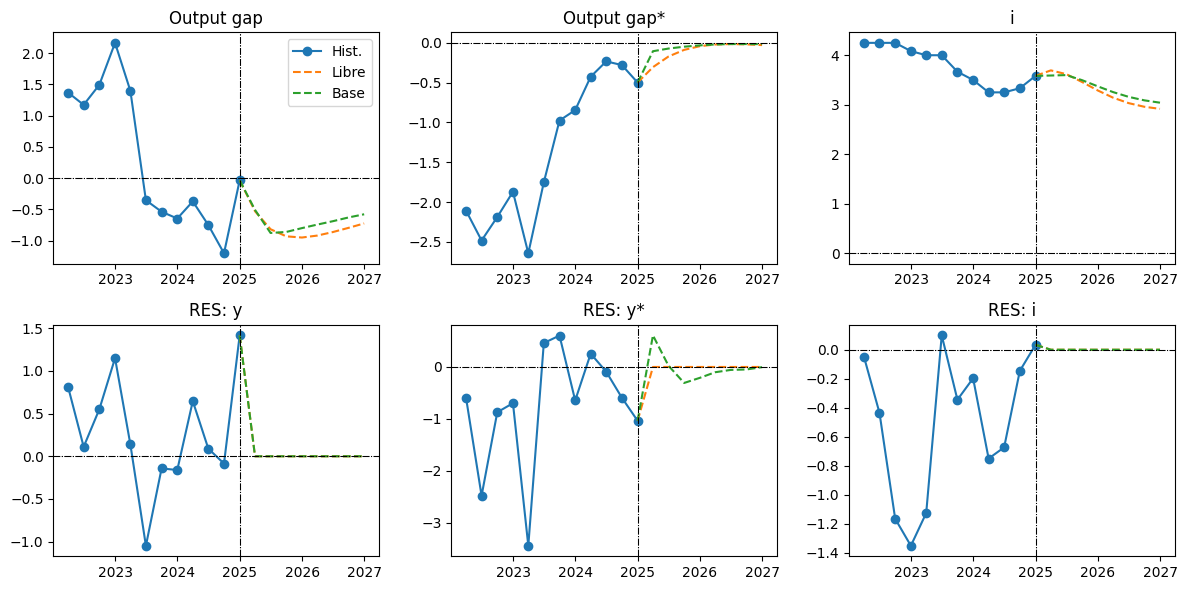

In [140]:
BDdict = {'Libre': FDB,'Base': UFDB_base}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

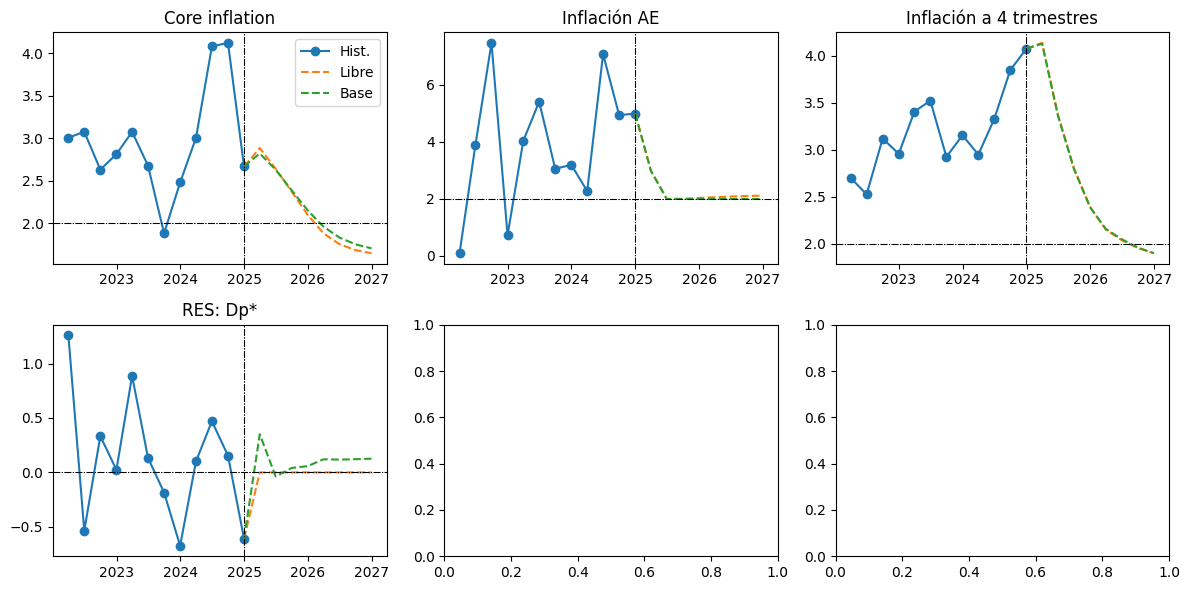

In [141]:
lista = ['Dpsae','Dpae','D4p','res_Dps']
listanames = ['Core inflation','Inflación AE','Inflación a 4 trimestres','RES: Dp*',]
listaSS = [2,2,2,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

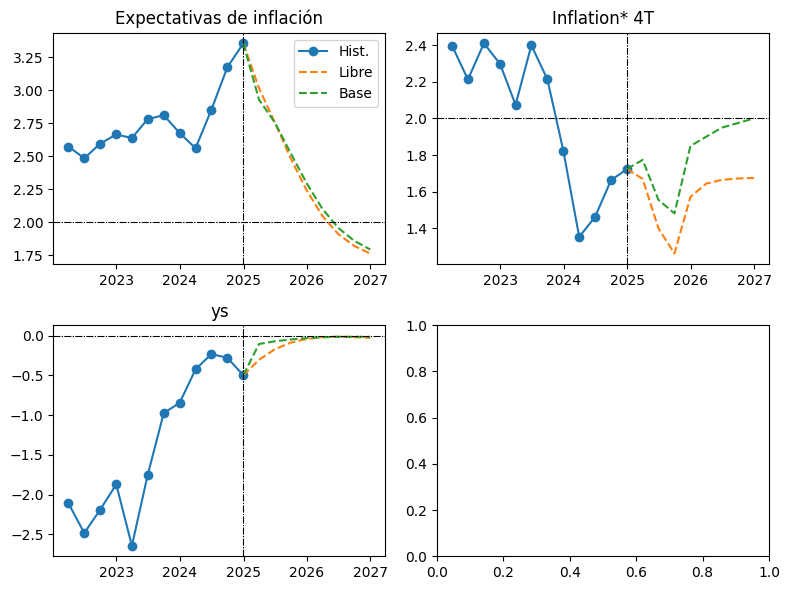

In [142]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['ED4p','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Expectativas de inflación','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,2)

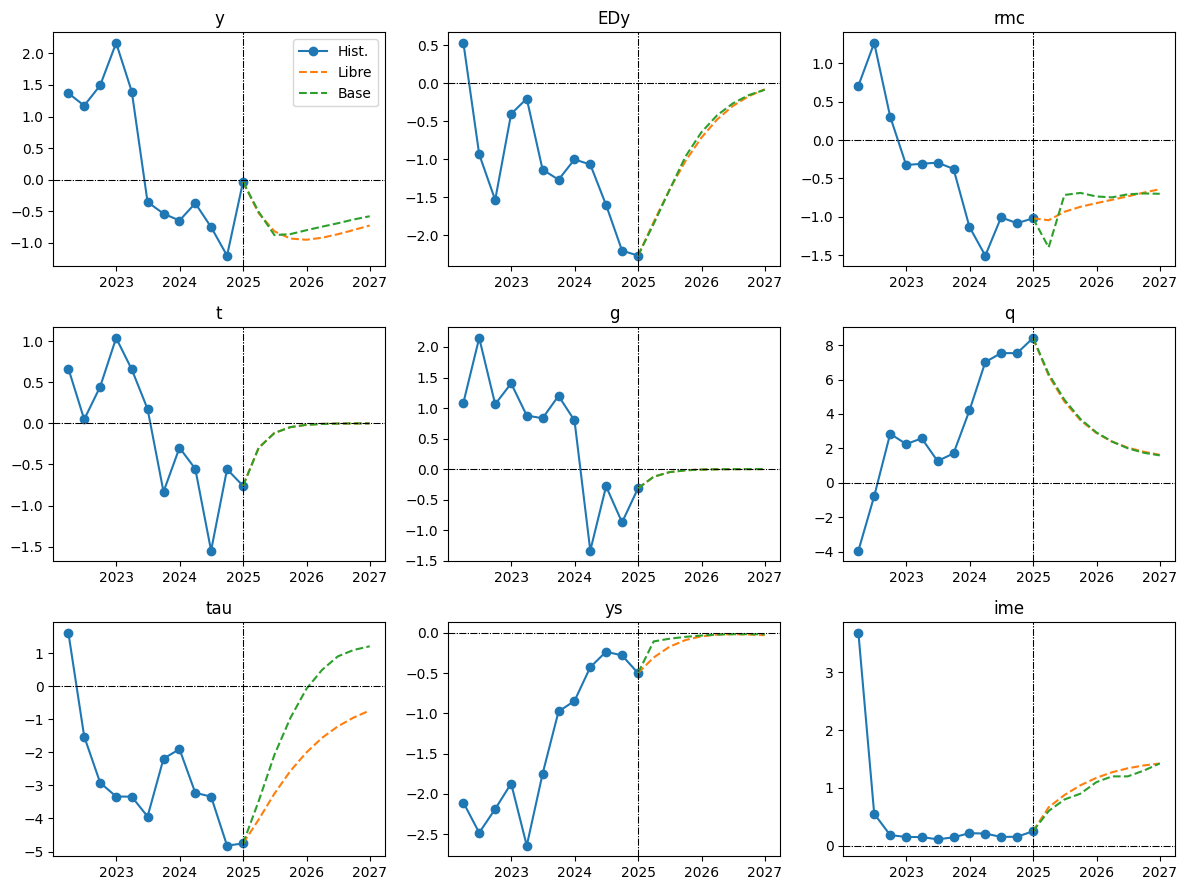

In [143]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','ime']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

In [144]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_base['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_base['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_base['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_base['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_base['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_base['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_base['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_base['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.508073   -0.876774   -0.860930   -0.799386   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.338987   -0.584984   -0.574412   
Confianza: aEy*EDy         -0.236136   -0.179241   -0.123038   -0.082089   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.418751   -0.214443   -0.206460   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.146817    0.111967    0.086006    0.067917   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.743107   -0.689126   -0.629096   -0.578192  
Inercia: (ay+aEy)*y(-1)    -0.533350   -0.495801   -0.459785   -0.419733  
Confianza: aEy*EDy         -0.053683   -0.033533   -0.019553   -0.010642  
Cond. Mon.: armc*rmc(-1)   -0.220301   -0.223787   -0.211822   -0.208610  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.055686    0.046556    0.040537    0.037005  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [145]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_base['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_base['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_base['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.823119    2.631969   
Inflación importada a 4 trimestres: bm*D4pm        0.156397    0.131118   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667614   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.041340    1.920524   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087287   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.388618    2.152955   
Inflación importada a 4 trimestres: bm*D4pm        0.159248    0.137323   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.622410    0.564862   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.757589    1.598677   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150630   -0.147908   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.961106    1.833949   
Inflación importada a 4 trimestres: bm*D4pm        0.124584    0.133414   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.509133    0.463764   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.464724    1.364437   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.137335   -0.127666   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.753487    1.706313  
Inflación importada a 4 trimestres: bm*D4pm        0.141782    0.149405  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.433694    0.414666  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.296404    1.250320  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.118392   -0.108079  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [146]:
# Regla de política monetaria
# i = fi*i(-1) + (1 - fi)*( ieq + fp*D4pdev + fy*( cfy*y + (1 - cfy)*y(-1) ) ) + m_res_i*res_i;

fi = 0.700000000000000
fp = 1.500000000000000
fy = 0.500000000000000
cfy = 0.500000000000000
m_res_i = (0.104900000000000)**0.5

hist2show = 4

i = UFDB_base['i'].values[-(hist2show+FH):].reshape(-1,1)
il = fi*UFDB_base['i'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ieq = (1-fi)*UFDB_base['ieq'].values[-(hist2show+FH):].reshape(-1,1)
D4pdev = (1-fi)*fp*UFDB_base['D4pdev'].values[-(hist2show+FH):].reshape(-1,1)
y = (1-fi)*fy*cfy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl = (1-fi)*fy*(1-cfy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_i = m_res_i*UFDB_base['res_i'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,il,ieq,D4pdev,y,yl,res_i], columns=['TPM: i','Inercia de la TPM: fi*i(-1)','TPM externa: (1-fi)*ieq','Desvío de la inflación meta: (1-fi)*fp*D4pdev','Brecha producto: (1-fi)*fy*cfy*y','Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*y(-1)','Residuo: m_res_i*res_i'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
TPM: i                                                3.250000    3.250000   
Inercia de la TPM: fi*i(-1)                           2.450000    2.275000   
TPM externa: (1-fi)*ieq                               1.082594    1.084530   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.036974    0.192674   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027904   -0.056245   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.048443   -0.027904   
Residuo: m_res_i*res_i                               -0.243221   -0.218054   

                                                    2024-09-30  2024-12-31  \
TPM: i                                                3.333333    3.583333   
Inercia de la TPM: fi*i(-1)                           2.275000    2.333333   
TPM externa: (1-fi)*ieq                               1.095351    1.106369   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.156627    0.225253   
Brecha producto: (1-fi)*fy*cfy*y                     -0.090127   -0.002590   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056245   -0.090127   
Residuo: m_res_i*res_i                               -0.047271    0.011096   

                                                    2025-03-31  2025-06-30  \
TPM: i                                                3.590239    3.598635   
Inercia de la TPM: fi*i(-1)                           2.508333    2.513167   
TPM externa: (1-fi)*ieq                               1.115685    1.120342   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.006916    0.068989   
Brecha producto: (1-fi)*fy*cfy*y                     -0.038106   -0.065758   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.002590   -0.038106   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2025-09-30  2025-12-31  \
TPM: i                                                3.496318    3.371692   
Inercia de la TPM: fi*i(-1)                           2.519045    2.447423   
TPM externa: (1-fi)*ieq                               1.122671    1.123836   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.015070   -0.075043   
Brecha producto: (1-fi)*fy*cfy*y                     -0.064570   -0.059954   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.065758   -0.064570   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2026-03-31  2026-06-30  \
TPM: i                                                3.255360    3.159327   
Inercia de la TPM: fi*i(-1)                           2.360184    2.278752   
TPM externa: (1-fi)*ieq                               1.124418    1.124709   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.113555   -0.136716   
Brecha producto: (1-fi)*fy*cfy*y                     -0.055733   -0.051684   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.059954   -0.055733   
Residuo: m_res_i*res_i                                0.000000    0.000000   

                                                    2026-09-30  2026-12-31  
TPM: i                                                3.088785    3.041262  
Inercia de la TPM: fi*i(-1)                           2.211529    2.162150  
TPM externa: (1-fi)*ieq                               1.124854    1.124927  
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.148731   -0.155268  
Brecha producto: (1-fi)*fy*cfy*y                     -0.047182   -0.043364  
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.051684   -0.047182  
Residuo: m_res_i*res_i                                0.000000    0.000000

In [147]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf    = rho_Ds*UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_base['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_base['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_base['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_base['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     7.440530    4.652535    3.621290   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.556282   -1.115605   
Expectativas de depreciación: rho_Ds*Ds     5.756168   -0.622513   -0.446242   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.038089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.824086   -0.298901    0.030417   
Expectativas de depreciación: rho_Ds*Ds    -0.329634   -0.119561    0.012167   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.894845   -4.720368   -4.557504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.140450    0.398975    0.664544  
Expectativas de depreciación: rho_Ds*Ds     0.056180    0.159590    0.265818  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.423058   -4.324299   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [148]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_base['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_base['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_base['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_base['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_base['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.590239    3.598635   
Crecimiento PBI real: DY             8.730329    2.179919    2.611523   
Brecha producto: y                  -0.034537   -0.508073   -0.876774   
Inflación SAE: Dpsae                 2.669623    2.823119    2.631969   
Inflación total: Dp                  3.708887    2.896670    2.348486   
Expectativa de inflación: ED4p       3.353472    2.928252    2.754944   
Tasa real en moneda nacional: Rmn    0.241861    0.661987    0.843691   
Depreciación nominal: Ds            14.390420   -1.556282   -1.115605   
Inflación AE: Dpae                   4.993248    2.987568    1.998147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.496318    3.371692    3.255360   
Crecimiento PBI real: DY             4.161840    4.356652    4.347487   
Brecha producto: y                  -0.860930   -0.799386   -0.743107   
Inflación SAE: Dpsae                 2.388618    2.152955    1.961106   
Inflación total: Dp                  2.214805    2.084544    1.978502   
Expectativa de inflación: ED4p       2.521218    2.293262    2.101109   
Tasa real en moneda nacional: Rmn    0.975100    1.078430    1.154250   
Depreciación nominal: Ds            -0.824086   -0.298901    0.030417   
Inflación AE: Dpae                   2.000000    2.000000    2.000000   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.159327    3.088785    3.041262  
Crecimiento PBI real: DY             4.350073    4.385930    4.360966  
Brecha producto: y                  -0.689126   -0.629096   -0.578192  
Inflación SAE: Dpsae                 1.833949    1.753487    1.706313  
Inflación total: Dp                  1.908217    1.863743    1.837667  
Expectativa de inflación: ED4p       1.957251    1.859659    1.793553  
Tasa real en moneda nacional: Rmn    1.202076    1.229127    1.247709  
Depreciación nominal: Ds             0.140450    0.398975    0.664544  
Inflación AE: Dpae                   2.000000    2.000000    2.000000

# Escenario Base: Más hawkish


In [149]:
UCond_basehawk = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_basehawk['Uvar']['var']['i'] = UFDB_base.i+0.25
    UCond_basehawk['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_basehawk['UShock'] or UCond_basehawk['UShock'][var_soft_tune].isna().all():
                UCond_basehawk['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [150]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_basehawk['UShock'])
print('Unanticipated Hardtunning')
print(UCond_basehawk['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_basehawk['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [151]:
UFDB_basehawk = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_basehawk)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [152]:
print(f'Impacto 2025: {round((UFDB_basehawk.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_basehawk.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: -0.0
Impacto 2026: -0.0


<ipython-input-152-3c145b7ac772>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_basehawk.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-152-3c145b7ac772>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_basehawk.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


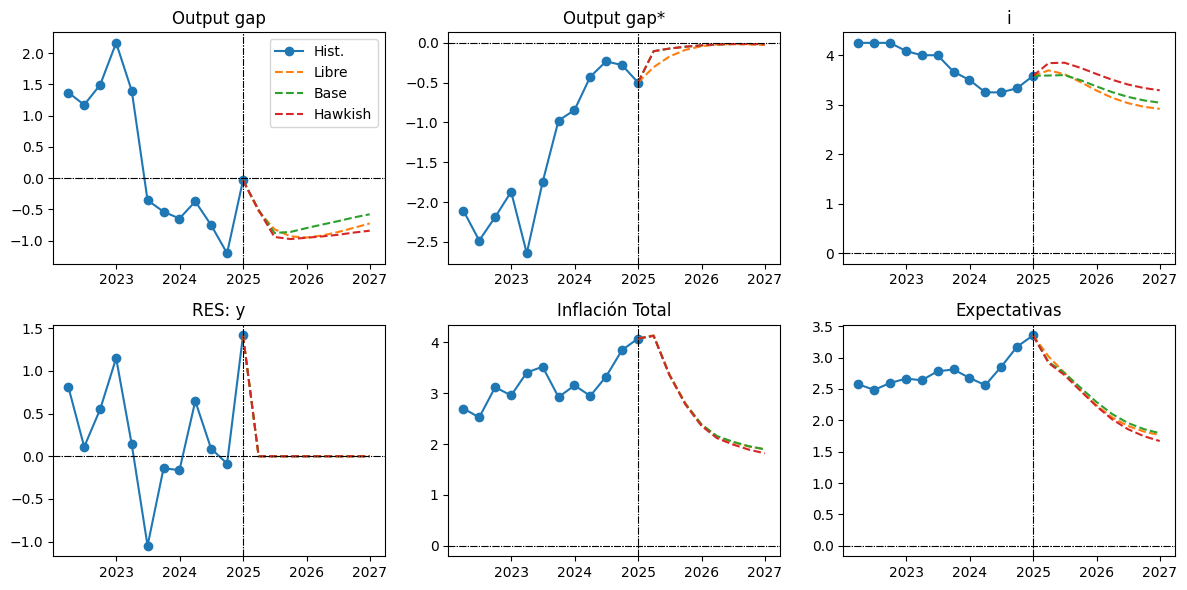

In [153]:
BDdicthawk = {'Libre': FDB,'Base': UFDB_base, 'Hawkish': UFDB_basehawk}
lista = ['y','ys', 'i','res_y','D4p', 'ED4p']
listanames = ['Output gap','Output gap*', 'i','RES: y','Inflación Total', 'Expectativas']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

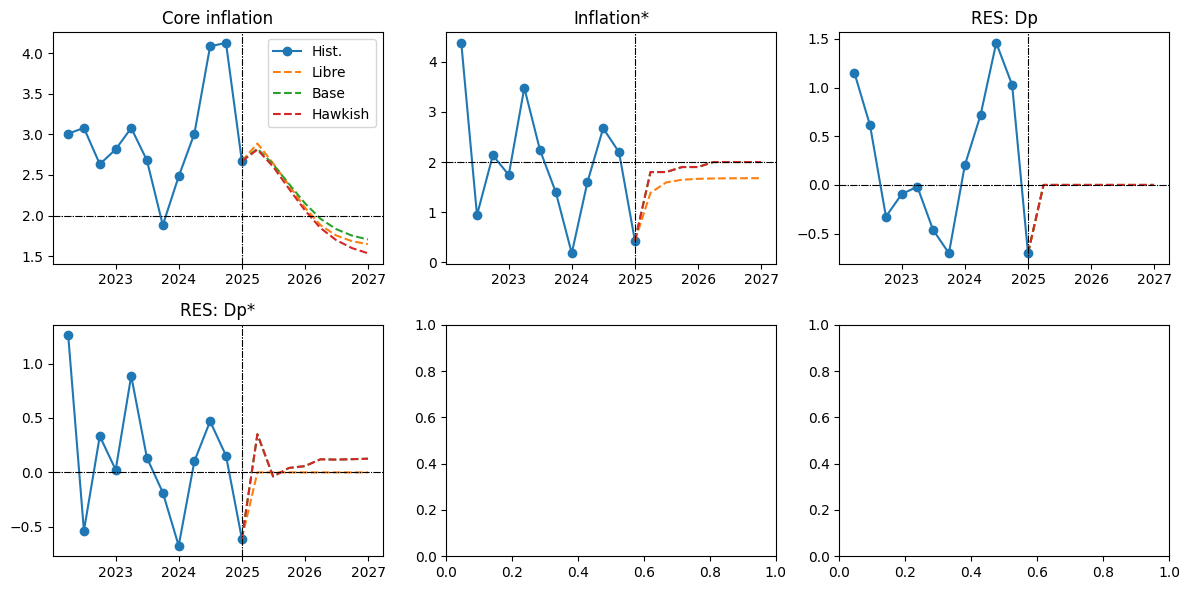

In [154]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

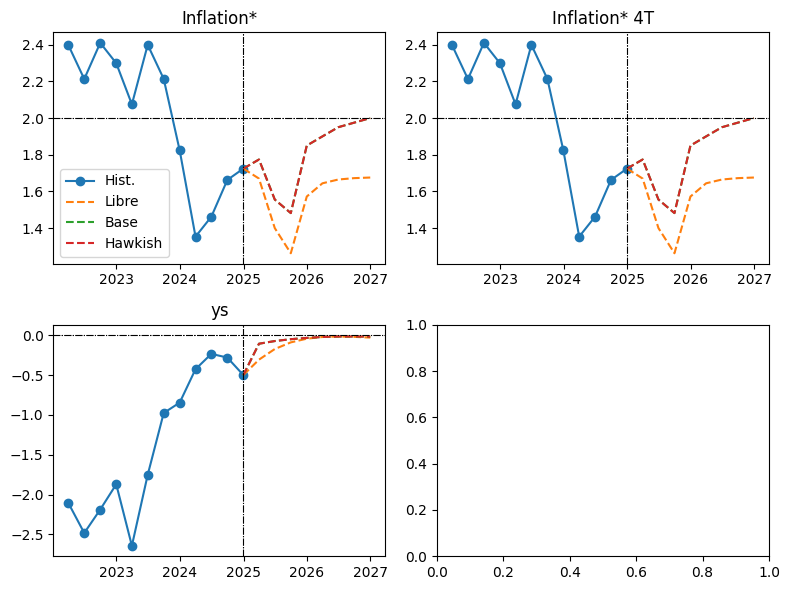

In [155]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,2,2)

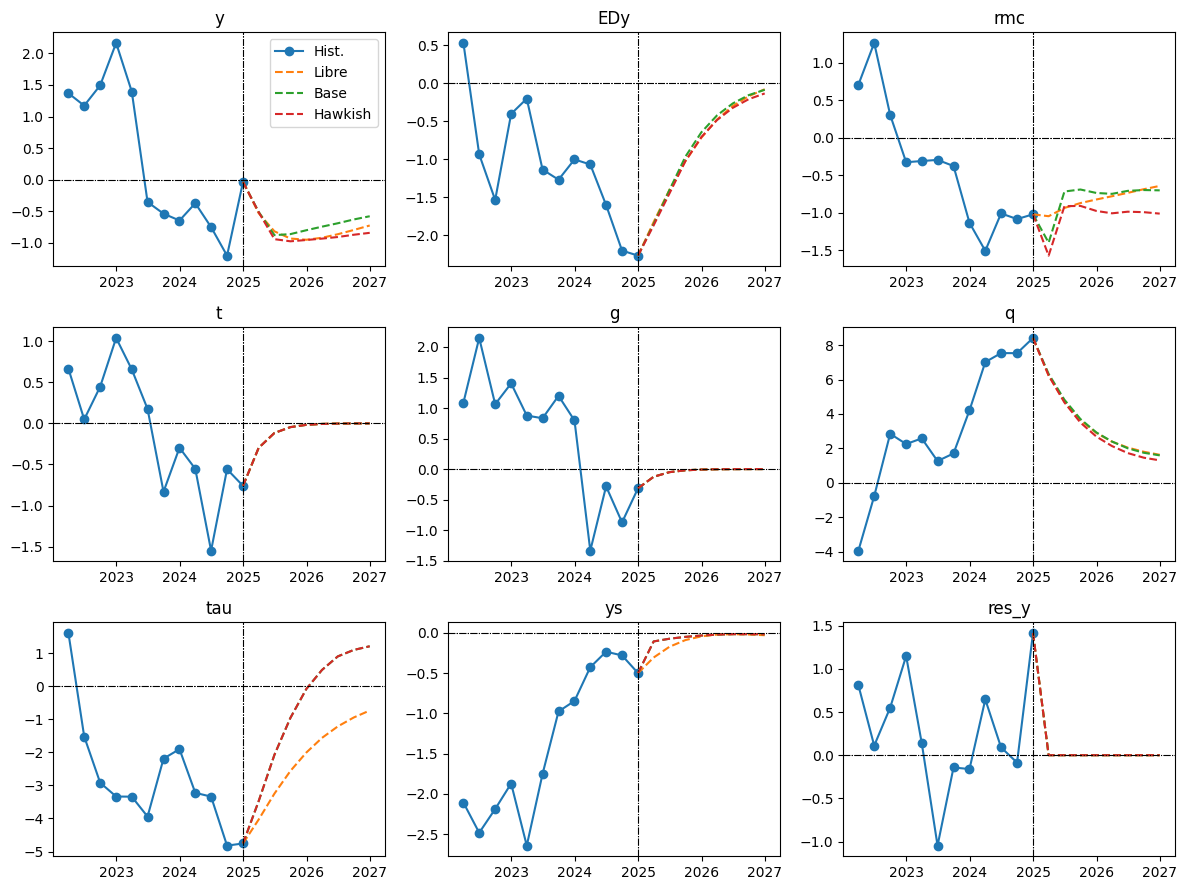

In [156]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdicthawk,lista,listanames,listaSS,FH,HH,3,3)

In [157]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_basehawk['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_basehawk['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_basehawk['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_basehawk['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_basehawk['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_basehawk['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_basehawk['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_basehawk['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_basehawk['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_basehawk['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.512527   -0.940938   -0.974607   -0.954169   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.341958   -0.627794   -0.650258   
Confianza: aEy*EDy         -0.238502   -0.184971   -0.130412   -0.090027   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.470551   -0.273135   -0.271863   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.144729    0.108305    0.081205    0.062321   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.932129   -0.906831   -0.871020   -0.840732  
Inercia: (ay+aEy)*y(-1)    -0.636622   -0.621917   -0.605038   -0.581144  
Confianza: aEy*EDy         -0.061537   -0.040942   -0.026336   -0.016731  
Cond. Mon.: armc*rmc(-1)   -0.292072   -0.301512   -0.295071   -0.296938  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.049561    0.040100    0.033899    0.030294  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [158]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_base['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_base['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_base['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_base['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_base['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.823119    2.631969   
Inflación importada a 4 trimestres: bm*D4pm        0.156397    0.131118   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667614   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.041340    1.920524   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087287   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.388618    2.152955   
Inflación importada a 4 trimestres: bm*D4pm        0.159248    0.137323   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.622410    0.564862   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.757589    1.598677   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150630   -0.147908   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.961106    1.833949   
Inflación importada a 4 trimestres: bm*D4pm        0.124584    0.133414   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.509133    0.463764   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.464724    1.364437   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.137335   -0.127666   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.753487    1.706313  
Inflación importada a 4 trimestres: bm*D4pm        0.141782    0.149405  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.433694    0.414666  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.296404    1.250320  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.118392   -0.108079  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [159]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_base['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsl     = rho_Ds*UFDB_base['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_base['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_base['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_base['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_base['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsl,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_basehawk.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.556282   -1.115605   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.622513   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.038089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.824086   -0.298901    0.030417   
Expectativas de depreciación: rho_Ds*Ds    -0.446242   -0.329634   -0.119561   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.894845   -4.720368   -4.557504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.140450    0.398975    0.664544  
Expectativas de depreciación: rho_Ds*Ds     0.012167    0.056180    0.159590  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.423058   -4.324299   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

# Escenario Base: Más dovish (FINAL)


In [160]:
UCond_basedove = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_basedove['Uvar']['var']['i'] = pd.Series(
    np.append(UFDB_base.i.iloc[-(FH):].values[1:], UFDB_base.i.iloc[-1]),
    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
)
    UCond_basedove['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_basedove['UShock'] or UCond_basedove['UShock'][var_soft_tune].isna().all():
                UCond_basedove['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [161]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_basedove['UShock'])
print('Unanticipated Hardtunning')
print(UCond_basedove['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_basedove['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [162]:
UFDB_basedove = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_basedove)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [163]:
print(f'Impacto 2025: {round((UFDB_basedove.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_basedove.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.0
Impacto 2026: 0.0


<ipython-input-163-ca3f2251f70b>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_basedove.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-163-ca3f2251f70b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_basedove.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


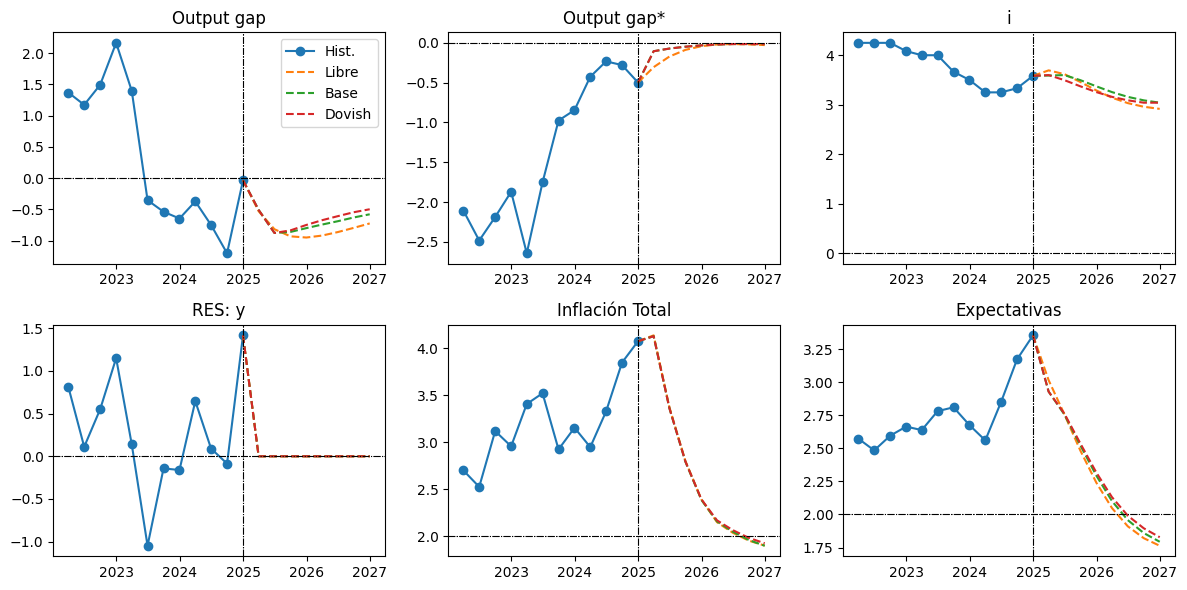

In [164]:
BDdictdove = {'Libre': FDB,'Base': UFDB_base, 'Dovish': UFDB_basedove}
lista = ['y','ys', 'i','res_y','D4p', 'ED4p']
listanames = ['Output gap','Output gap*', 'i','RES: y','Inflación Total', 'Expectativas']
listaSS = [0,0,0,0,2,2]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

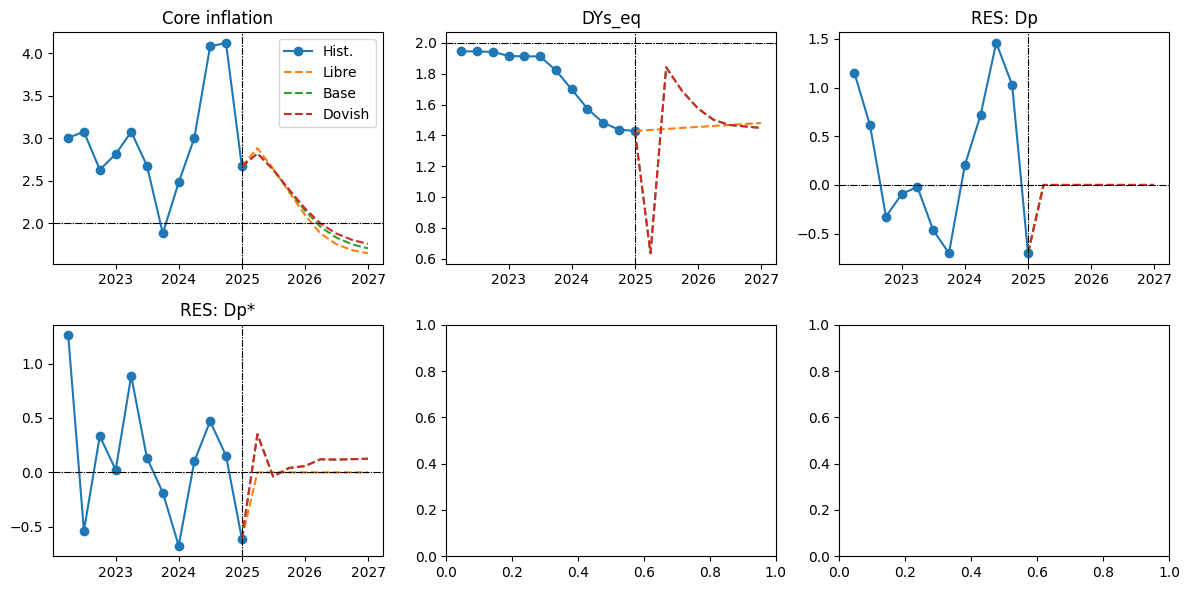

In [165]:
lista = ['Dpsae','DYs_eq','res_Dpsae','res_Dps']
listanames = ['Core inflation','DYs_eq','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

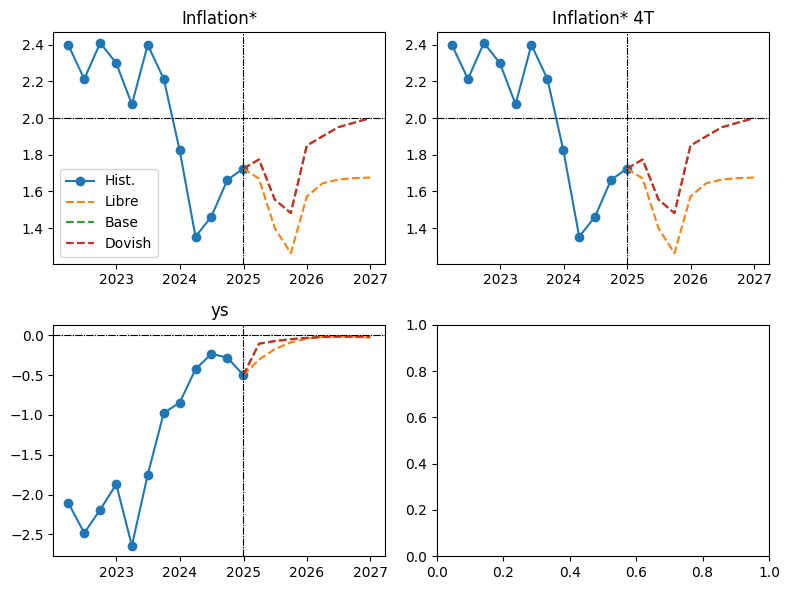

In [166]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,2,2)

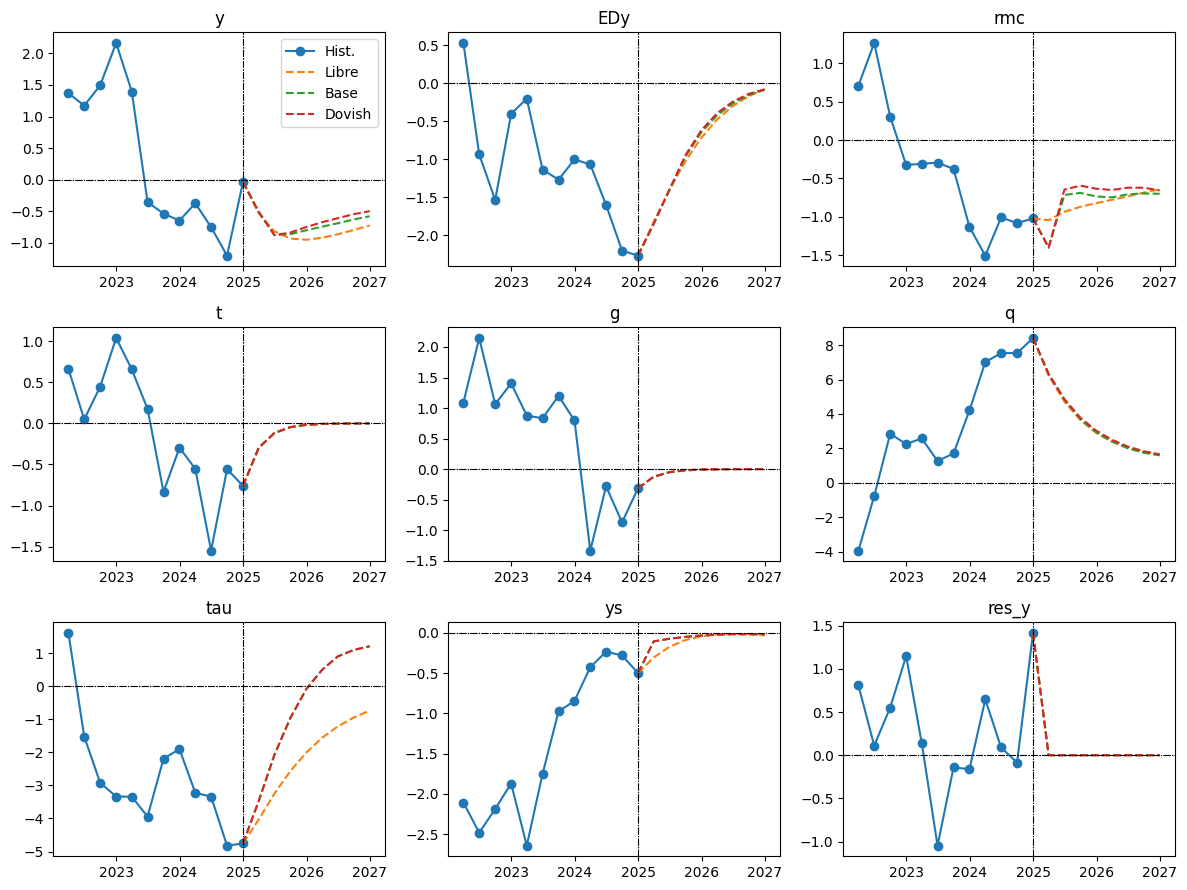

In [167]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdictdove,lista,listanames,listaSS,FH,HH,3,3)

In [168]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_basedove['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_basedove['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_basedove['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_basedove['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_basedove['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_basedove['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_basedove['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_basedove['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_basedove['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.508223   -0.876957   -0.835935   -0.748664   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.339086   -0.585105   -0.557736   
Confianza: aEy*EDy         -0.236216   -0.178385   -0.120537   -0.078657   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.420491   -0.193474   -0.178042   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.146747    0.112769    0.087653    0.070113   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.673256   -0.608352   -0.545260   -0.497630  
Inercia: (ay+aEy)*y(-1)    -0.499508   -0.449196   -0.405893   -0.363797  
Confianza: aEy*EDy         -0.050155   -0.030546   -0.017463   -0.009816  
Cond. Mon.: armc*rmc(-1)   -0.190229   -0.194930   -0.186010   -0.186219  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.058096    0.048881    0.042579    0.038414  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [169]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_basedove['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_basedove['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_basedove['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_basedove['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_basedove['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_basedove['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.822714    2.636301   
Inflación importada a 4 trimestres: bm*D4pm        0.156383    0.131219   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667518   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.040950    1.924877   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.087313   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.401040    2.178321   
Inflación importada a 4 trimestres: bm*D4pm        0.160313    0.139447   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.623435    0.567800   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.767953    1.614688   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.150661   -0.143614   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         1.999299    1.881839   
Inflación importada a 4 trimestres: bm*D4pm        0.127558    0.136792   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.515131    0.472796   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.485230    1.387916   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128620   -0.115665   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.806317    1.758657  
Inflación importada a 4 trimestres: bm*D4pm        0.144395    0.150858  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.445019    0.427159  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.321418    1.274315  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.104515   -0.093676  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [170]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_basedove['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsl     = rho_Ds*UFDB_basedove['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_basedove['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_basedove['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_basedove['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_basedove['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsl,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.571318   -0.931799   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.628527   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.038089   -4.894845   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.607609   -0.105024    0.181939   
Expectativas de depreciación: rho_Ds*Ds    -0.372719   -0.243044   -0.042009   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.720368   -4.557504   -4.423058   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.242589    0.458431    0.639200  
Expectativas de depreciación: rho_Ds*Ds     0.072776    0.097036    0.183372  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.324299   -4.257767   -4.257767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [171]:
# Tasa de interés real externa expresada en S/ de equilibrio
# Rme_eq = zme + cY_me*(DY_eq(+1)-DY_ss) + cR_me*(DYs_eq(+1)-DYs_ss)

# Brecha de la tasa de interés real externa expresada en S/
# rme = Rme - Rme_eq;

zme       = 0
cY_me     = 0.507100000000000
cR_me     = 0.461900000000000
DYs_ss    = 2.100000000000000
rho_zme   = 0.533200000000000
Rme_ss    = 0
m_res_zme = (0.140000000000000)**0.5
DY_ss     = 5.300000000000000

hist2show = 4

Rme_eq = UFDB_basedove['Rme_eq'].values[-(hist2show+FH):].reshape(-1,1)
zme    = UFDB_basedove['zme'].values[-(hist2show+FH):].reshape(-1,1)
DY_eq  = cY_me*UFDB_basedove['DY_eq'].values[-(hist2show+FH):].reshape(-1,1)
DYs_eq = cR_me*UFDB_basedove['DYs_eq'].values[-(hist2show+FH):].reshape(-1,1)

rme    = UFDB_basedove['rme'].values[-(hist2show+FH):].reshape(-1,1)
Rme    = UFDB_basedove['Rme'].values[-(hist2show+FH):].reshape(-1,1)
Rme_eq    = UFDB_basedove['Rme_eq'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Rme_eq,zme,DY_eq,DYs_eq,rme,Rme,Rme_eq], columns=['Tasa real natural en ME: Rme_eq','Otros factores tasa real natural ME: zme','Crecimiento PBI potencial: DY_eq','Crecimiento PBI externo potencial: DYs_eq','Brecha tasa de interes ME: rme','Tasa real en ME: Rme','Tasa real en ME natural: Rme_eq'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Tasa real natural en ME: Rme_eq             -1.004736   -0.981108   -0.905274   
Otros factores tasa real natural ME: zme     0.018867    0.036220    0.062949   
Crecimiento PBI potencial: DY_eq             1.897321    1.945915    2.015943   
Crecimiento PBI externo potencial: DYs_eq    0.726357    0.684101    0.663674   
Brecha tasa de interes ME: rme               3.659627    2.784010    3.378257   
Tasa real en ME: Rme                         2.654891    1.802902    2.472983   
Tasa real en ME natural: Rme_eq             -1.004736   -0.981108   -0.905274   

                                           2024-12-31  2025-03-31  2025-06-30  \
Tasa real natural en ME: Rme_eq             -0.887264   -1.263249   -0.715686   
Otros factores tasa real natural ME: zme     0.041666    0.022216    0.011846   
Crecimiento PBI potencial: DY_eq             2.059679    2.065959    2.072176   
Crecimiento PBI externo potencial: DYs_eq    0.659628    0.293211    0.850564   
Brecha tasa de interes ME: rme               3.494115    3.265125    2.060104   
Tasa real en ME: Rme                         2.606851    2.001876    1.344418   
Tasa real en ME natural: Rme_eq             -0.887264   -1.263249   -0.715686   

                                           2025-09-30  2025-12-31  2026-03-31  \
Tasa real natural en ME: Rme_eq             -0.785276   -0.834085   -0.863316   
Otros factores tasa real natural ME: zme     0.006316    0.003368    0.001796   
Crecimiento PBI potencial: DY_eq             2.078330    2.084423    2.090455   
Crecimiento PBI externo potencial: DYs_eq    0.779702    0.727285    0.693315   
Brecha tasa de interes ME: rme               1.679661    1.555305    1.417869   
Tasa real en ME: Rme                         0.894385    0.721220    0.554552   
Tasa real en ME natural: Rme_eq             -0.785276   -0.834085   -0.863316   

                                           2026-06-30  2026-09-30  2026-12-31  
Tasa real natural en ME: Rme_eq             -0.873612   -0.872629   -0.871526  
Otros factores tasa real natural ME: zme     0.000957    0.000511    0.000272  
Crecimiento PBI potencial: DY_eq             2.096427    2.102339    2.108192  
Crecimiento PBI externo potencial: DYs_eq    0.677790    0.673322    0.668824  
Brecha tasa de interes ME: rme               1.225277    1.156889    1.145032  
Tasa real en ME: Rme                         0.351666    0.284260    0.273506  
Tasa real en ME natural: Rme_eq             -0.873612   -0.872629   -0.871526

In [172]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_basedove['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_basedove['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_basedove['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_basedove['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_basedove['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_basedove['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_basedove['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_basedove['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_basedove['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_basedove.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.598635    3.496318   
Crecimiento PBI real: DY             8.730329    2.179321    2.611391   
Brecha producto: y                  -0.034537   -0.508223   -0.876957   
Inflación SAE: Dpsae                 2.669623    2.822714    2.636301   
Inflación total: Dp                  3.708887    2.896446    2.350880   
Expectativa de inflación: ED4p       3.353472    2.927691    2.761188   
Tasa real en moneda nacional: Rmn    0.241861    0.670944    0.735130   
Depreciación nominal: Ds            14.390420   -1.571318   -0.931799   
Inflación AE: Dpae                   4.993248    2.987568    1.998147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.371692    3.255360    3.159327   
Crecimiento PBI real: DY             4.262549    4.459561    4.424005   
Brecha producto: y                  -0.835935   -0.748664   -0.673256   
Inflación SAE: Dpsae                 2.401040    2.178321    1.999299   
Inflación total: Dp                  2.221671    2.098565    1.999612   
Expectativa de inflación: ED4p       2.536085    2.316229    2.130526   
Tasa real en moneda nacional: Rmn    0.835607    0.939130    1.028801   
Depreciación nominal: Ds            -0.607609   -0.105024    0.181939   
Inflación AE: Dpae                   2.000000    2.000000    2.000000   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.088785    3.041262    3.041262  
Crecimiento PBI real: DY             4.393762    4.398177    4.347870  
Brecha producto: y                  -0.608352   -0.545260   -0.497630  
Inflación SAE: Dpsae                 1.881839    1.806317    1.758657  
Inflación total: Dp                  1.934687    1.892944    1.866600  
Expectativa de inflación: ED4p       1.990932    1.895541    1.827973  
Tasa real en moneda nacional: Rmn    1.097854    1.145721    1.213289  
Depreciación nominal: Ds             0.242589    0.458431    0.639200  
Inflación AE: Dpae                   2.000000    2.000000    2.000000

# Escenario de riesgo 5: Fenómeno del Niño (6%) (FINAL)

In [173]:
UCond_riesgo5 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo5.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_riesgo5['Uvar']['var']['i'] = pd.Series(
    np.append(UFDB_base.i.iloc[-(FH):].values[0], UFDB_base.i.iloc[-(FH):].values[0:-1]),
    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
)
    UCond_riesgo5['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo5['UShock'] or UCond_riesgo5['UShock'][var_soft_tune].isna().all():
                UCond_riesgo5['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [174]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo5['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo5['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo5['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_EDy  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  res_Dpm  \
2025-03-31 -0.928175        0.0  0.034531        0.0       0.0      0.0   
2025-06-30 -0.252591        0.0 -0.028215        0.0       0.0      0.0   
2025-09-30 -0.024282        0.0 -0.013382        0.0       0.0      0.0   
2025-12-31 -0.238605        0.0 -0.006415        0.0       0.0      0.0   
2026-03-31  0.107211        0.0 -0.010039        0.0       0.0      0.0   
2026-06-30 -0.136297        0.0 -0.012791        0.0       0.0      0.0   
2026-09-30 -0.118196        0.0 -0.012693        0.0       0.0      0.0   
2026-12-31 -0.099627        0.0 -0.020483        0.0       0.0      0.0   

            res_Meta  res_i  res_ieq  res_imn  ...         res_g   res_DTI  \
2025-03-31       0.0    0.0      0.0      0.0  ... -1.554312e-16  0.262743   
2025-06-30       0.0    0.0      0.0      0.0  ... -1.110223e-17  0.262743   
2025-09-30       0.0    0.0      0.0 

In [175]:
UFDB_riesgo5 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo5)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [176]:
print(f'Impacto 2025: {round((UFDB_riesgo5.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo5.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.03
Impacto 2026: 0.02


<ipython-input-176-bbdb733e2076>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo5.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-176-bbdb733e2076>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo5.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


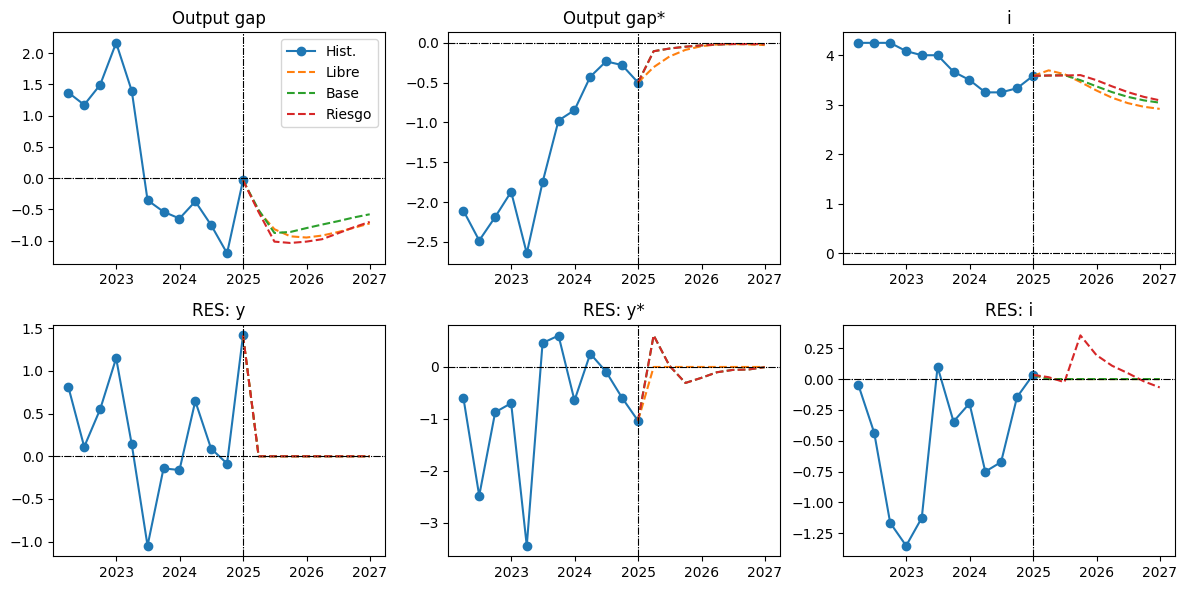

In [177]:
BDdict5 = {'Libre': FDB,'Base': UFDB_base, 'Riesgo': UFDB_riesgo5}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

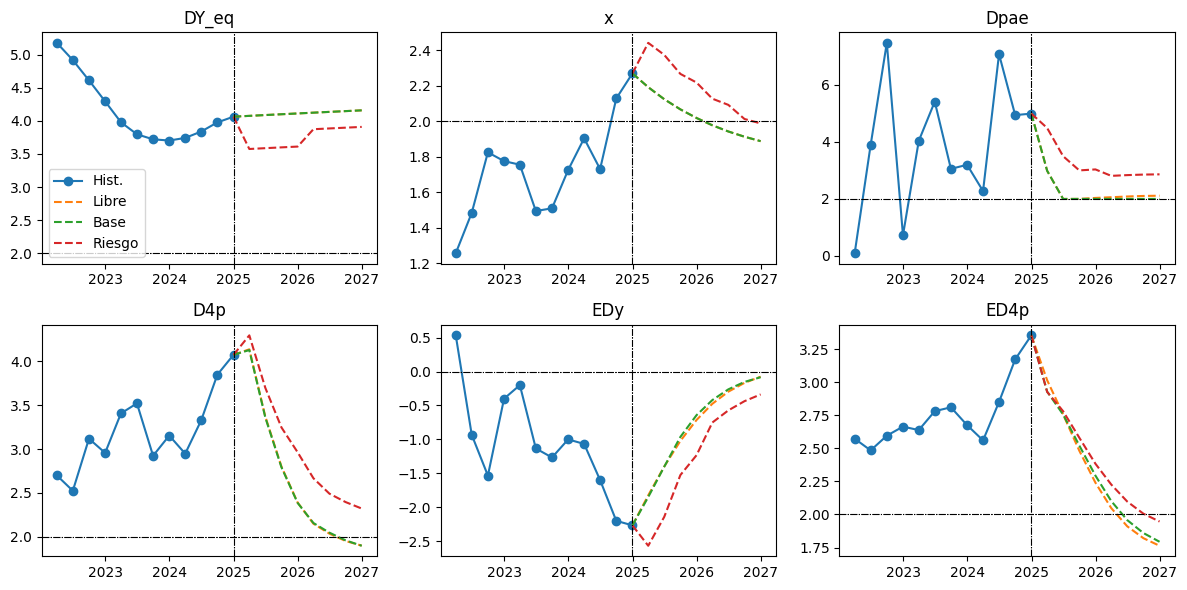

In [178]:
#Choques por Fenomeno del niño
lista = ['DY_eq','x','Dpae','D4p','EDy','ED4p']
listanames = lista
listaSS = [2,2,2,2,0,2]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

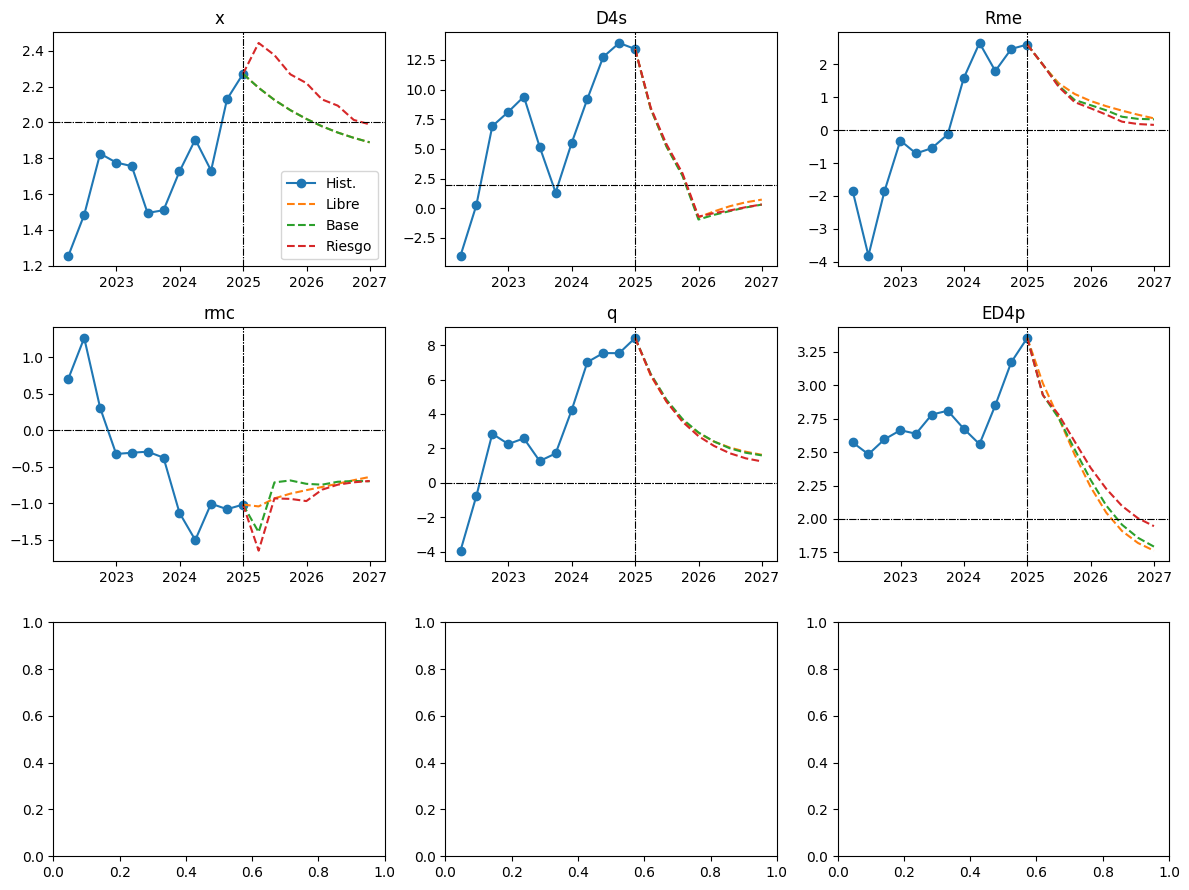

In [179]:
#Empezamos por el aumento del riesgo pais
lista = ['x','D4s','Rme','rmc','q','ED4p']
listanames = lista
listaSS = [2,2,0,0,0,2]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

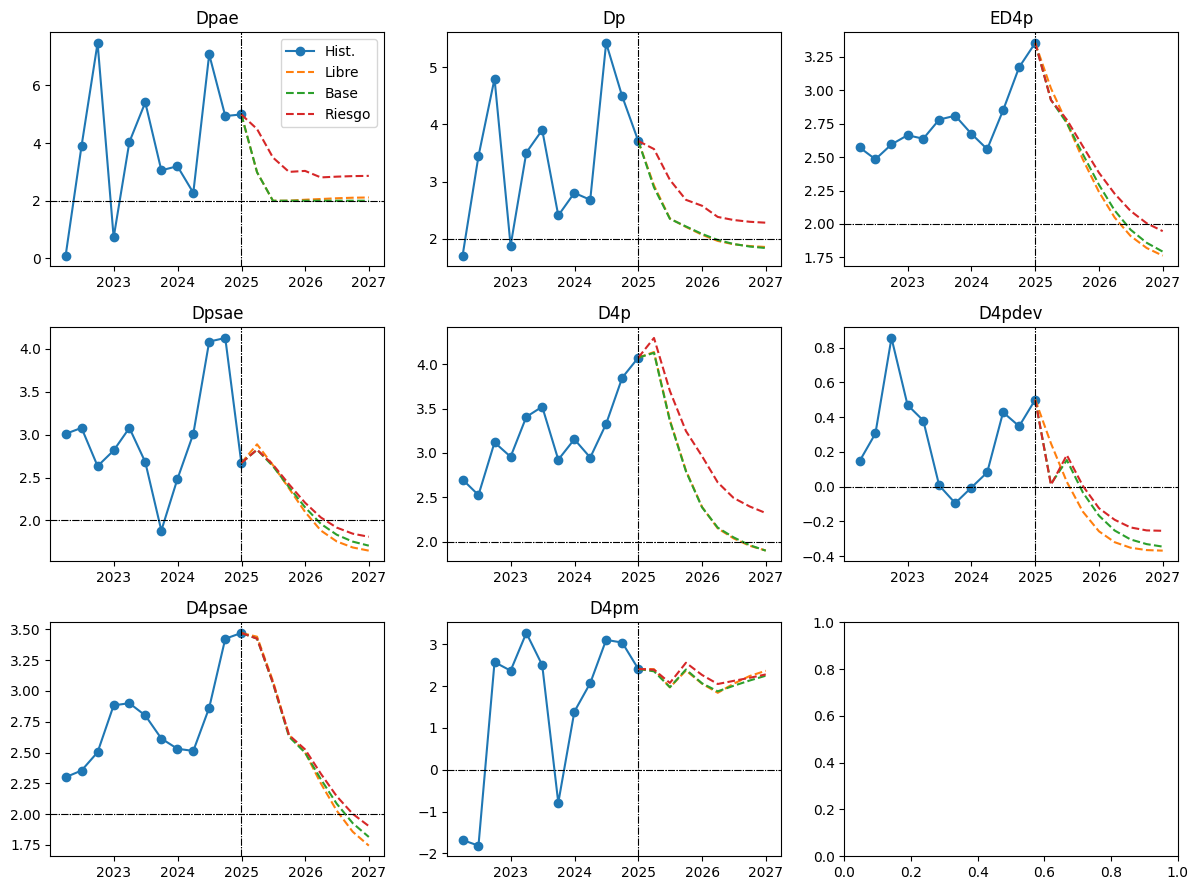

In [180]:
#Aumento de AE
lista = ['Dpae','Dp','ED4p','Dpsae','D4p','D4pdev','D4psae','D4pm']
listanames = lista
listaSS = [2,2,2,2,2,0,2,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

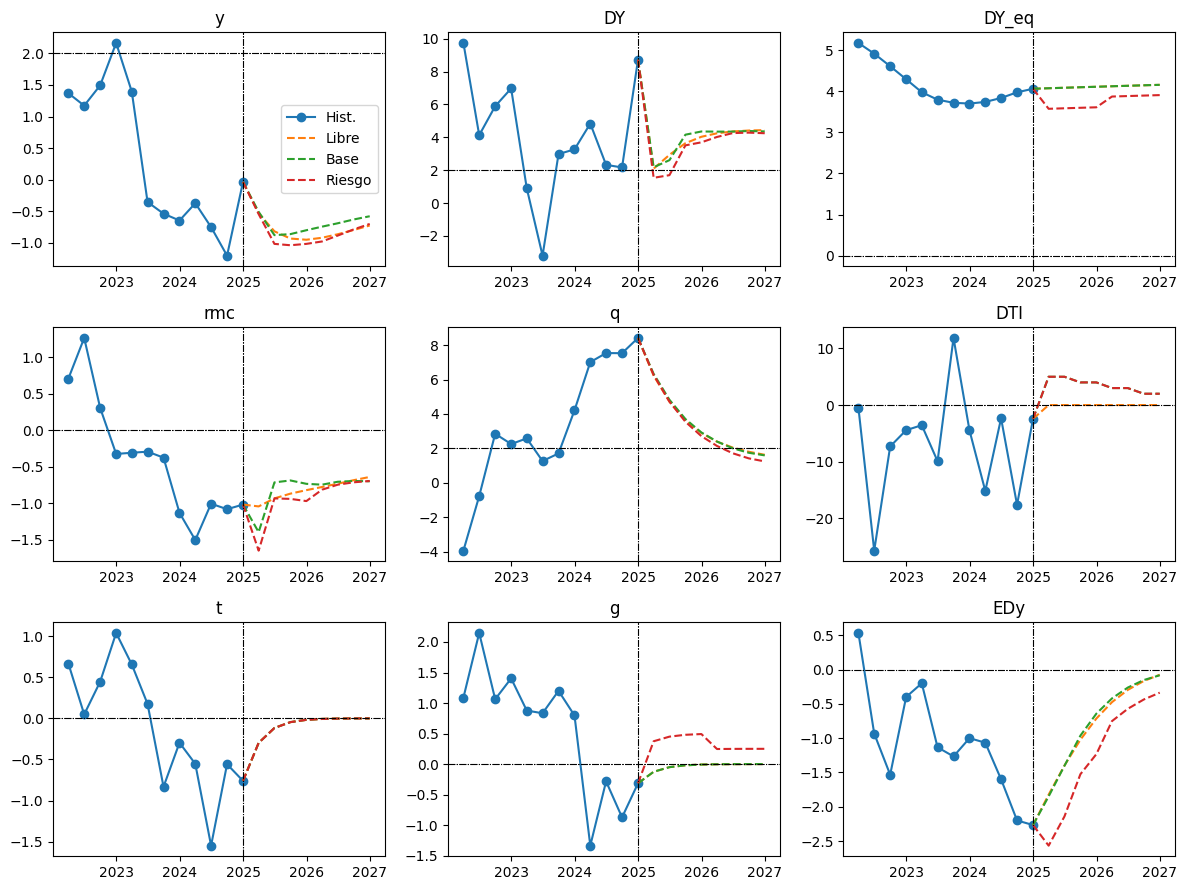

In [181]:
# Brecha de producto
lista = ['y','DY','DY_eq','rmc','q','DTI','t','g','EDy']
listanames = lista
listaSS = [2,2,0,0,2,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

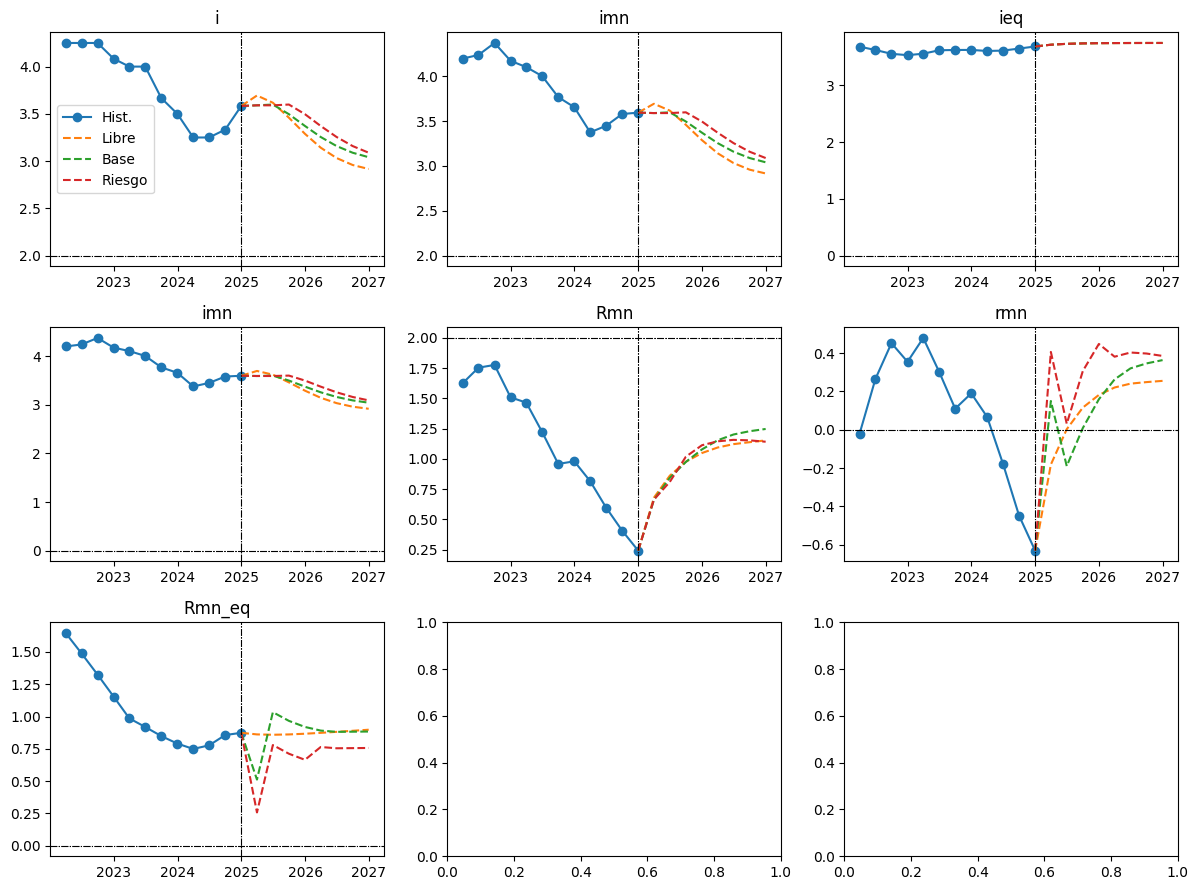

In [182]:
# Tasa de interes nacional
lista = ['i','imn','ieq','imn','Rmn','rmn','Rmn_eq']
listanames = lista
listaSS = [2,2,0,0,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict5,lista,listanames,listaSS,FH,HH,3,3)

In [183]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo5['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo5['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo5['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo5['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo5['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo5['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo5['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo5['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo5['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.543529   -1.015582   -1.037069   -1.015387   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.362643   -0.677596   -0.691933   
Confianza: aEy*EDy         -0.327842   -0.273558   -0.194838   -0.157456   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.494726   -0.280098   -0.282201   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g            0.043048    0.051762    0.055258    0.056660   
TCRM: aq*q                  0.145466    0.109509    0.082334    0.062944   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.977507   -0.883650   -0.785847   -0.699956  
Inercia: (ay+aEy)*y(-1)    -0.677466   -0.652193   -0.589571   -0.524317  
Confianza: aEy*EDy         -0.095962   -0.073089   -0.055784   -0.043043  
Cond. Mon.: armc*rmc(-1)   -0.291132   -0.244434   -0.223801   -0.214071  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g            0.028423    0.028649    0.028739    0.028776  
TCRM: aq*q                  0.049712    0.039827    0.032983    0.028888  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [184]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_riesgo5['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_riesgo5['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_riesgo5['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_riesgo5['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_riesgo5['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_riesgo5['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.824376    2.650535   
Inflación importada a 4 trimestres: bm*D4pm        0.158944    0.137941   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.667911   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.040050    1.938061   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.093378   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.420965    2.206258   
Inflación importada a 4 trimestres: bm*D4pm        0.169974    0.150577   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.626801    0.572512   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.798667    1.661337   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.174477   -0.178168   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.035363    1.916872   
Inflación importada a 4 trimestres: bm*D4pm        0.136234    0.141204   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.521738    0.481325   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.551835    1.462280   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.174443   -0.167936   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.845834    1.809843  
Inflación importada a 4 trimestres: bm*D4pm        0.146086    0.151390  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.453304    0.436504  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.398255    1.356957  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.151811   -0.135008  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [185]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_riesgo5['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf     = rho_Ds*UFDB_riesgo5['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_riesgo5['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_riesgo5['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_riesgo5['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_riesgo5['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.169996   -0.720846   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.467998   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.840000    1.120000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.420333    3.325546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.026334   -5.026334   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.710423   -0.223928    0.028733   
Expectativas de depreciación: rho_Ds*Ds    -0.288338   -0.284169   -0.089571   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.260000    1.540000    1.680000   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.175243    3.107210    2.979572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.038089   -4.894845   -4.720368   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.168686    0.396373    0.695303  
Expectativas de depreciación: rho_Ds*Ds     0.011493    0.067474    0.158549  
Tasa interbancaria ME: (1+rho_Ds)*ime       1.680000    1.820000    1.992625  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.930741    2.819372    2.784324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.557504   -4.423058   -4.324299  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [186]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_riesgo5['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_riesgo5['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_riesgo5['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_riesgo5['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_riesgo5['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_riesgo5['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_riesgo5['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_riesgo5['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_riesgo5['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_riesgo5.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.590239    3.590239   
Crecimiento PBI real: DY             8.730329    1.538096    1.698115   
Brecha producto: y                  -0.034537   -0.543529   -1.015582   
Inflación SAE: Dpsae                 2.669623    2.824376    2.650535   
Inflación total: Dp                  3.708887    3.568255    3.029638   
Expectativa de inflación: ED4p       3.353472    2.926401    2.780100   
Tasa real en moneda nacional: Rmn    0.241861    0.663837    0.810139   
Depreciación nominal: Ds            14.390420   -1.169996   -0.720846   
Inflación AE: Dpae                   4.993248    4.487568    3.498147   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.598635    3.496318    3.371692   
Crecimiento PBI real: DY             3.512513    3.697206    4.023891   
Brecha producto: y                  -1.037069   -1.015387   -0.977507   
Inflación SAE: Dpsae                 2.420965    2.206258    2.035363   
Inflación total: Dp                  2.680191    2.576767    2.381306   
Expectativa de inflación: ED4p       2.580143    2.383147    2.226069   
Tasa real en moneda nacional: Rmn    1.018493    1.113171    1.145623   
Depreciación nominal: Ds            -0.710423   -0.223928    0.028733   
Inflación AE: Dpae                   3.000552    3.034655    2.808835   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.255360    3.159327    3.088785  
Crecimiento PBI real: DY             4.259578    4.287020    4.250913  
Brecha producto: y                  -0.883650   -0.785847   -0.699956  
Inflación SAE: Dpsae                 1.916872    1.845834    1.809843  
Inflación total: Dp                  2.327500    2.296650    2.280525  
Expectativa de inflación: ED4p       2.097604    2.005763    1.946520  
Tasa real en moneda nacional: Rmn    1.157756    1.153564    1.142265  
Depreciación nominal: Ds             0.168686    0.396373    0.695303  
Inflación AE: Dpae                   2.834970    2.853786    2.862211

# Escenario de riesgo 6: Expansión demanda externa China (10%)

In [481]:
UCond_riesgo6 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo6.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_riesgo6['Uvar']['var']['i'] = UFDB_base.i+0.25
    UCond_riesgo6['Uvar']['shock'].append('res_i')

#if tpmfija:
#    UCond_riesgo6['Uvar']['var']['i'] = pd.Series(
#    np.append(UFDB_base.i.iloc[-(FH):].values[0], UFDB_base.i.iloc[-(FH):].values[0:-1]),
#    index=UFDB_base.i.index[-FH:]  # Mantiene la coherencia del índice
#)+0.25
#    UCond_riesgo6['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo6['UShock'] or UCond_riesgo6['UShock'][var_soft_tune].isna().all():
                UCond_riesgo6['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [482]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo6['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo6['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo6['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_EDy  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  res_Dpm  \
2025-03-31  1.259783        0.0  0.034531        0.0       0.0      0.0   
2025-06-30  0.311962        0.0 -0.028215        0.0       0.0      0.0   
2025-09-30  0.266814        0.0 -0.013382        0.0       0.0      0.0   
2025-12-31  0.323849        0.0 -0.006415        0.0       0.0      0.0   
2026-03-31  0.363776        0.0 -0.010039        0.0       0.0      0.0   
2026-06-30  0.381988        0.0 -0.012791        0.0       0.0      0.0   
2026-09-30  0.391477        0.0 -0.012693        0.0       0.0      0.0   
2026-12-31  0.402446        0.0 -0.020483        0.0       0.0      0.0   

            res_Meta  res_i  res_ieq  res_imn  ...         res_g   res_DTI  \
2025-03-31       0.0    0.0      0.0      0.0  ... -1.554312e-16  0.262743   
2025-06-30       0.0    0.0      0.0      0.0  ... -1.110223e-17  0.262743   
2025-09-30       0.0    0.0      0.0 

In [483]:
UFDB_riesgo6 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo6)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [484]:
print(f'Impacto 2025: {round((UFDB_riesgo6.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo6.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: 0.0
Impacto 2026: 0.01


<ipython-input-484-a8b250576057>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo6.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-484-a8b250576057>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo6.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


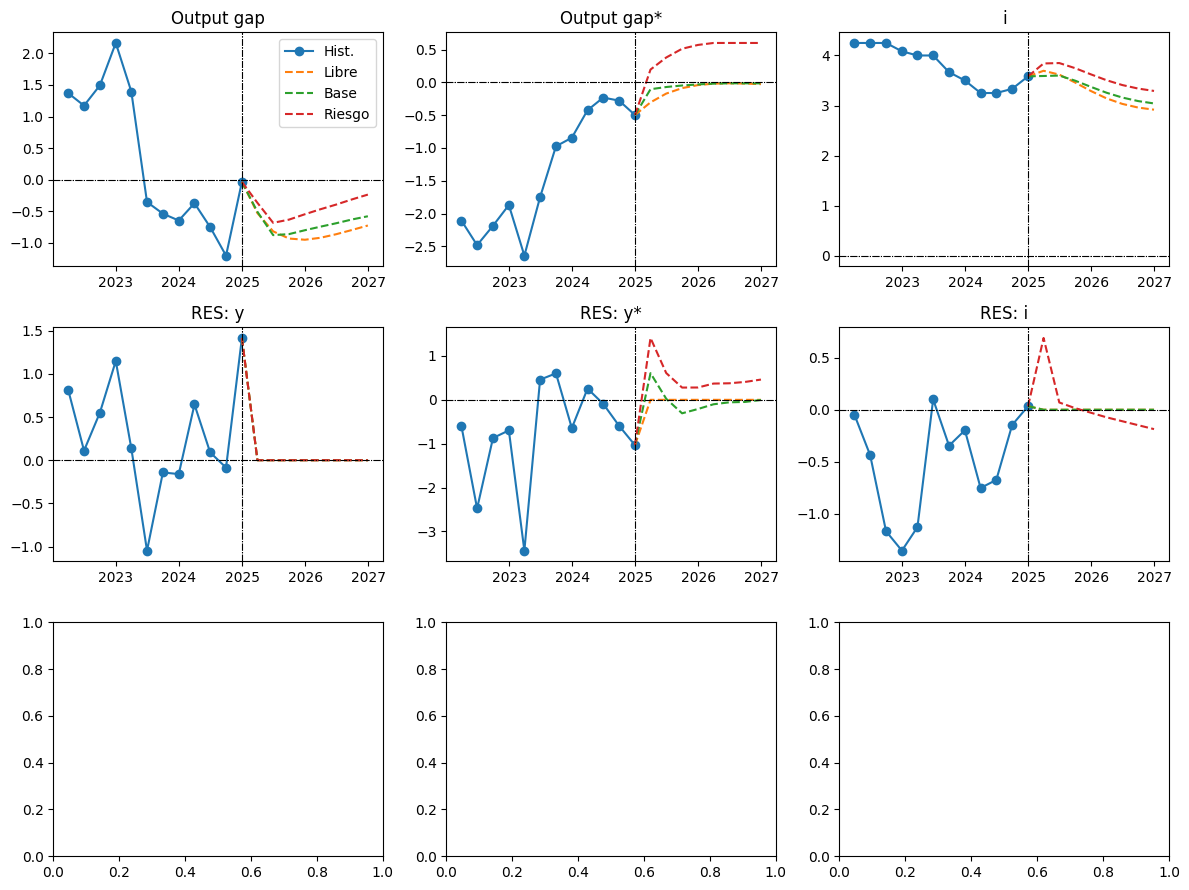

In [485]:
BDdict6 = {'Libre': FDB,'Base': UFDB_base, 'Riesgo': UFDB_riesgo6}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,3,3)

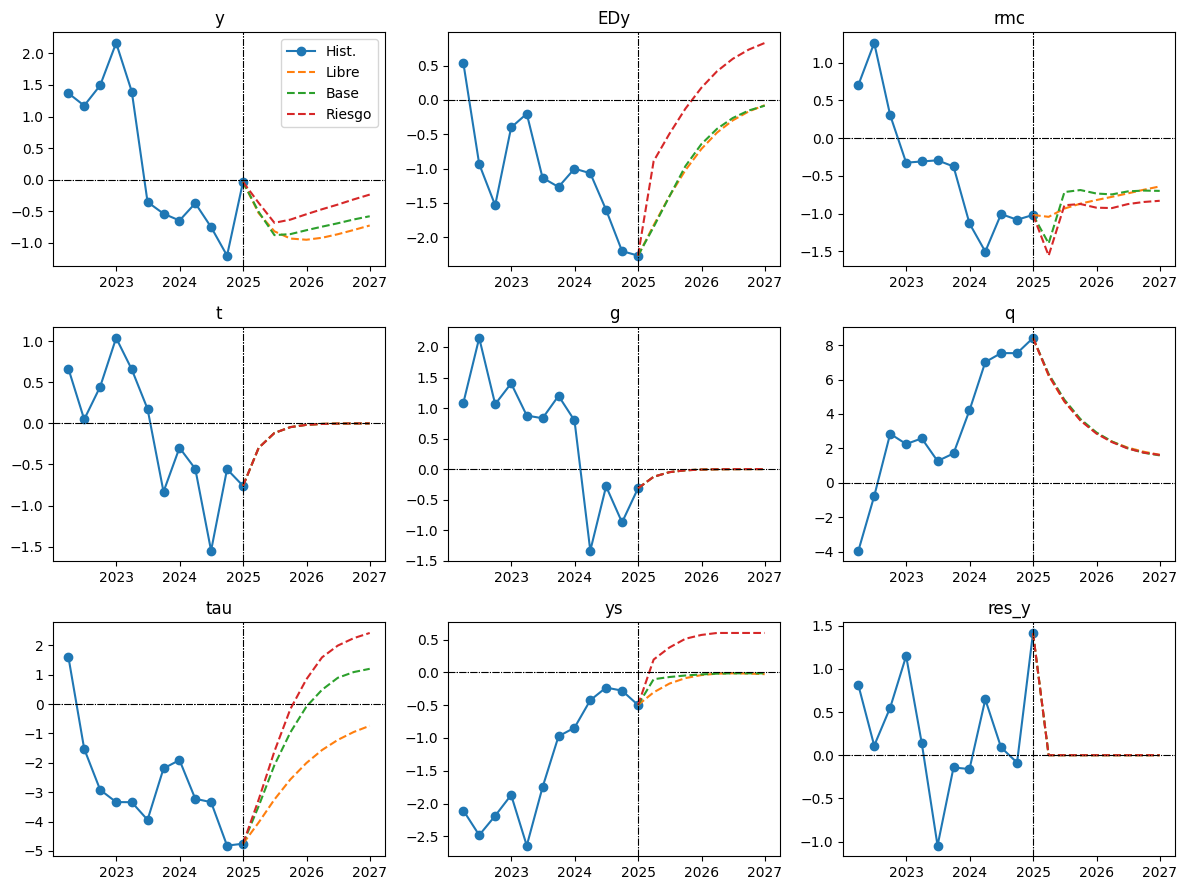

In [486]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,3,3)

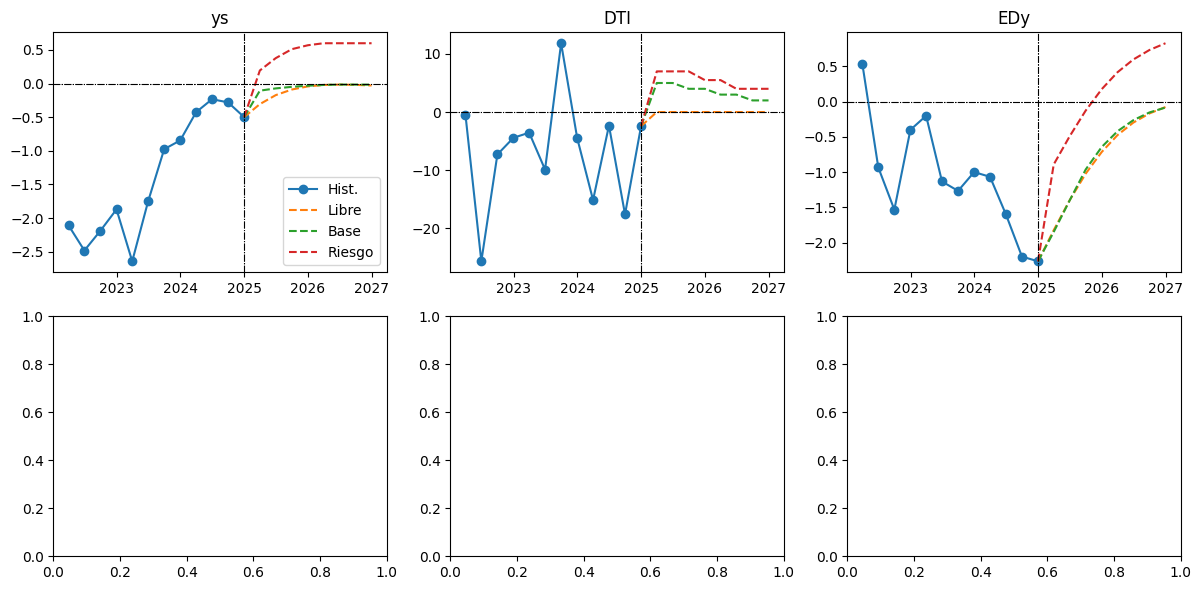

In [487]:
#Choques por mayor demanda externa
lista = ['ys','DTI','EDy']
listanames = lista
listaSS = [0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

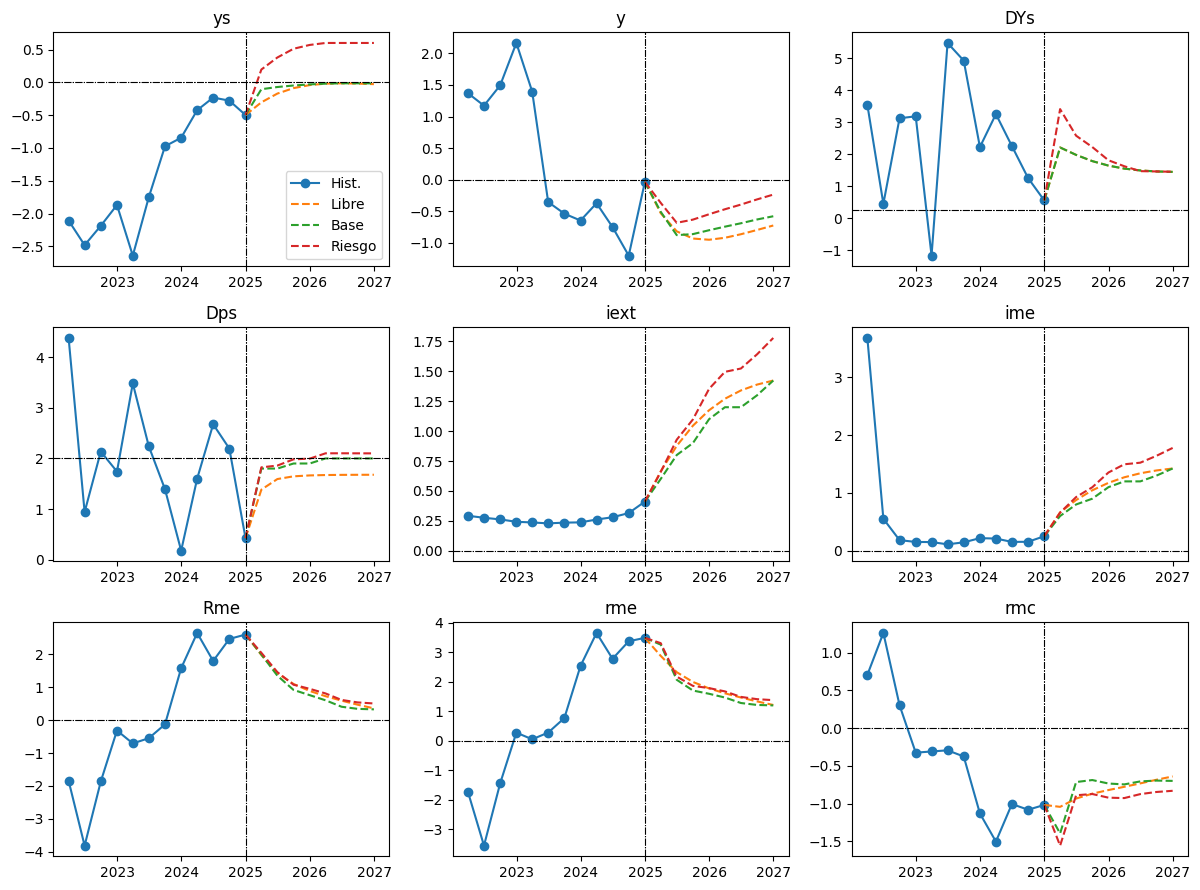

In [488]:
# Mayor brecha producto externa
lista = ['ys','y','DYs','Dps','iext','ime','Rme','rme','rmc']
listanames = lista
listaSS = [0,0,0.25,2,0,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,3,3)

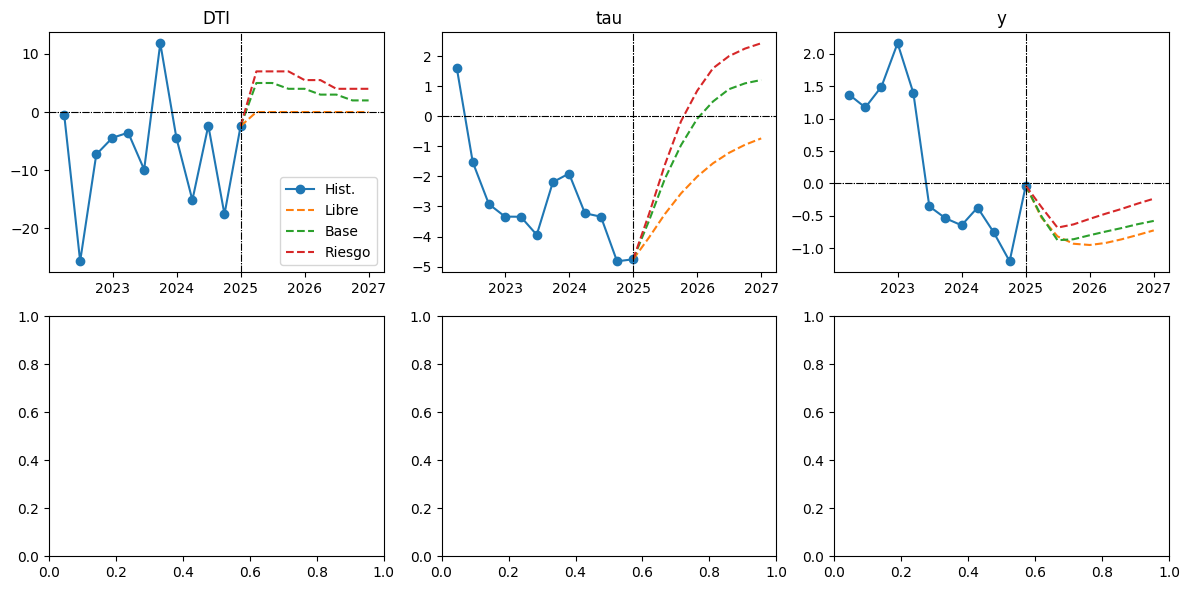

In [489]:
# Términos de intercambio favorable
lista = ['DTI','tau','y']
listanames = lista
listaSS = [0,0,0,0,0,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,2,3)

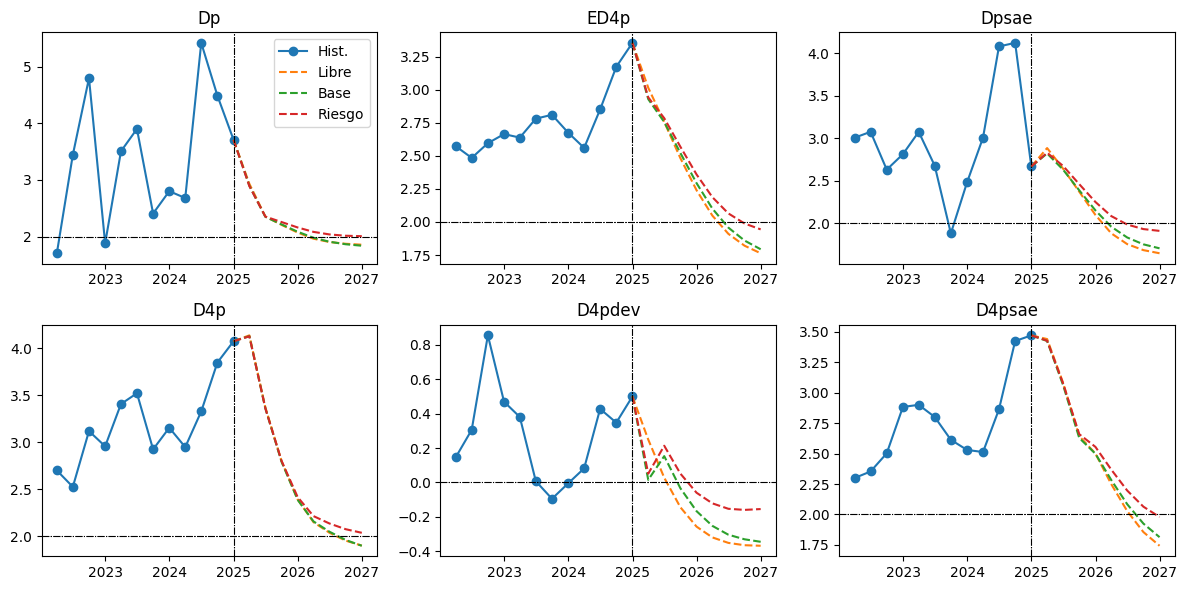

In [490]:
# Inflación
lista = ['Dp','ED4p','Dpsae','D4p','D4pdev','D4psae']
listanames = lista
listaSS = [2,2,2,2,0,2,2]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,2,3)

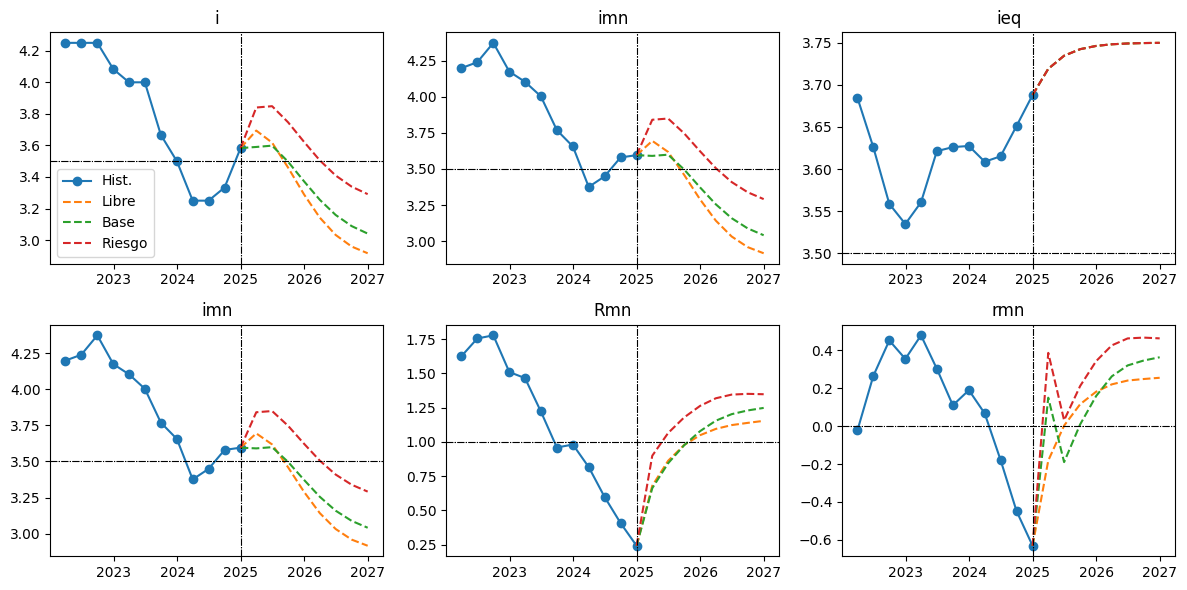

In [491]:
#Tasa de interes nacional
lista = ['i','imn','ieq','imn','Rmn','rmn']
listanames = lista
listaSS = [3.5,3.5,3.5,3.5,1,0]
fig, axs = HTS.plotTSforecast(BDdict6,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

In [492]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo6['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo6['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo6['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo6['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo6['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo6['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo6['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo6['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.366205   -0.682120   -0.631522   -0.546307   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.244332   -0.455110   -0.421351   
Confianza: aEy*EDy         -0.113765   -0.062858   -0.016152    0.022718   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.467440   -0.267028   -0.262018   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.145228    0.109861    0.084045    0.066451   
Imp. TI: atau*tau          -0.066754   -0.032950   -0.003360    0.017337   
Socios: ays*ys              0.010737    0.020853    0.028197    0.031407   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.467539   -0.393498   -0.311396   -0.235364  
Inercia: (ay+aEy)*y(-1)    -0.364496   -0.311942   -0.262542   -0.207763  
Confianza: aEy*EDy          0.053325    0.076537    0.093684    0.105994  
Cond. Mon.: armc*rmc(-1)   -0.276586   -0.278211   -0.262386   -0.253929  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.054837    0.046287    0.040747    0.037574  
Imp. TI: atau*tau           0.032662    0.040908    0.046096    0.049723  
Socios: ays*ys              0.033060    0.033060    0.033060    0.033060  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

In [493]:
# Curva de Phillips
# Dpsae = bm*D4pm + (1 - bm)*(bsae*Dpsae(-1) + (1 - bsae)*ED4p) +  by*(cy*y + (1 - cy)*y(-1)) + m_res_Dpsae*res_Dpsae;

bm = 0.066400000000000
bsae = 0.253300000000000
by = 0.171800000000000
cy = 0.000000000000000
m_res_Dpsae = (0.725200000000000)**0.5

hist2show = 4

Dpsae  = UFDB_riesgo6['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
D4pm   = bm*UFDB_riesgo6['D4pm'].values[-(hist2show+FH):].reshape(-1,1)
Dpsael = (1-bm)*bsae*UFDB_riesgo6['Dpsae'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ED4p   = (1-bm)*(1-bsae)*UFDB_riesgo6['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
y      = by*cy*UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl     = by*(1-cy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_Dpsae = m_res_Dpsae*UFDB_riesgo6['res_Dpsae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Dpsae,D4pm,Dpsael,ED4p,y,yl,res_Dpsae], columns=['Inflación trimestral SAE anualizada: Dpsae','Inflación importada a 4 trimestres: bm*D4pm','Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)','Expectativas de inflación: (1-bm)*(1-bsae)*ED4p','Brecha producto: by*cy*y','Inercia de brecha producto: by*(1-cy)*y(-1)','Residuo: m_res_Dsae*res_Dpsae'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
Inflación trimestral SAE anualizada: Dpsae         3.008166    4.082850   
Inflación importada a 4 trimestres: bm*D4pm        0.137678    0.206255   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.586868    0.711374   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.784431    1.986789   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.110966   -0.063920   
Residuo: m_res_Dsae*res_Dpsae                      0.610154    1.242351   

                                                 2024-09-30  2024-12-31  \
Inflación trimestral SAE anualizada: Dpsae         4.124964    2.669623   
Inflación importada a 4 trimestres: bm*D4pm        0.202014    0.160133   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.965516    0.975475   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.211417    2.337770   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.128839   -0.206452   
Residuo: m_res_Dsae*res_Dpsae                      0.874856   -0.597302   

                                                 2025-03-31  2025-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.831583    2.676012   
Inflación importada a 4 trimestres: bm*D4pm        0.155604    0.128382   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.631315    0.669615   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    2.050598    1.940930   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.005933   -0.062914   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2025-09-30  2025-12-31  \
Inflación trimestral SAE anualizada: Dpsae         2.461645    2.251907   
Inflación importada a 4 trimestres: bm*D4pm        0.155623    0.133789   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.632826    0.582132   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.790384    1.644482   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.117188   -0.108495   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-03-31  2026-06-30  \
Inflación trimestral SAE anualizada: Dpsae         2.086069    1.986440   
Inflación importada a 4 trimestres: bm*D4pm        0.122509    0.134248   
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.532533    0.493315   
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.524882    1.439200   
Brecha producto: by*cy*y                          -0.000000   -0.000000   
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.093856   -0.080323   
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000   

                                                 2026-09-30  2026-12-31  
Inflación trimestral SAE anualizada: Dpsae         1.932945    1.911681  
Inflación importada a 4 trimestres: bm*D4pm        0.144531    0.153027  
Inercia de la inflación: (1-bm)*bsae*Dpsae(-1)     0.469755    0.457104  
Expectativas de inflación: (1-bm)*(1-bsae)*ED4p    1.386262    1.355048  
Brecha producto: by*cy*y                          -0.000000   -0.000000  
Inercia de brecha producto: by*(1-cy)*y(-1)       -0.067603   -0.053498  
Residuo: m_res_Dsae*res_Dpsae                      0.000000    0.000000

In [494]:
# Paridad descubierta de tasas de interés modificada
# Ds = rho_Ds*Ds(+1) + (1 + rho_Ds)*( ime + x - imn + m_res_Ds*res_Ds )

rho_Ds = 0.400000000000000
m_res_Ds = (77.208300000000000)**0.5

hist2show = 4

Ds     = UFDB_riesgo6['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dsf     = rho_Ds*UFDB_riesgo6['Ds'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ime    = (1+rho_Ds)*UFDB_riesgo6['ime'].values[-(hist2show+FH):].reshape(-1,1)
x      = (1+rho_Ds)*UFDB_riesgo6['x'].values[-(hist2show+FH):].reshape(-1,1)
imn    = -(1+rho_Ds)*UFDB_riesgo6['imn'].values[-(hist2show+FH):].reshape(-1,1)
res_Ds = (1+rho_Ds)*m_res_Ds*UFDB_riesgo6['res_Ds'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[Ds,Dsf,ime,x,imn,res_Ds], columns=['Depreciación trimestral: Ds','Expectativas de depreciación: rho_Ds*Ds','Tasa interbancaria ME: (1+rho_Ds)*ime','Prima por riesgo cambiario: (1+rho_Ds)*x','Tasa interbancaria MN: (1+rho_Ds)*imn','Residuo: (1+rho_Ds)*m_res_Ds*res_Ds'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
Depreciación trimestral: Ds                18.601325   11.631337    9.053224   
Expectativas de depreciación: rho_Ds*Ds     6.571768    7.440530    4.652535   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.293113    0.211960    0.214993   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.666438    2.423655    2.981263   
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.725980   -4.827667   -5.011440   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        20.853347   14.541468   11.248642   

                                          2024-12-31  2025-03-31  2025-06-30  \
Depreciación trimestral: Ds                14.390420   -1.921463   -1.341464   
Expectativas de depreciación: rho_Ds*Ds     3.621290    5.756168   -0.768585   
Tasa interbancaria ME: (1+rho_Ds)*ime       0.349673    0.921744    1.299481   
Prima por riesgo cambiario: (1+rho_Ds)*x    3.179125    3.070333    2.975546   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.033467   -5.376334   -5.388089   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds        16.531741    0.000000    0.000000   

                                          2025-09-30  2025-12-31  2026-03-31  \
Depreciación trimestral: Ds                -0.915983   -0.290596    0.106949   
Expectativas de depreciación: rho_Ds*Ds    -0.536586   -0.366393   -0.116238   
Tasa interbancaria ME: (1+rho_Ds)*ime       1.536966    1.895509    2.094523   
Prima por riesgo cambiario: (1+rho_Ds)*x    2.895243    2.827210    2.769572   
Tasa interbancaria MN: (1+rho_Ds)*imn      -5.244845   -5.070368   -4.907504   
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000   

                                          2026-06-30  2026-09-30  2026-12-31  
Depreciación trimestral: Ds                 0.257495    0.539388    0.817395  
Expectativas de depreciación: rho_Ds*Ds     0.042780    0.102998    0.215755  
Tasa interbancaria ME: (1+rho_Ds)*ime       2.133516    2.300187    2.491281  
Prima por riesgo cambiario: (1+rho_Ds)*x    2.720741    2.679372    2.644324  
Tasa interbancaria MN: (1+rho_Ds)*imn      -4.773058   -4.674299   -4.607767  
Residuo: (1+rho_Ds)*m_res_Ds*res_Ds         0.000000    0.000000    0.000000

In [495]:
# Regla de política monetaria
# i = fi*i(-1) + (1 - fi)*( ieq + fp*D4pdev + fy*( cfy*y + (1 - cfy)*y(-1) ) ) + m_res_i*res_i;

fi = 0.700000000000000
fp = 1.500000000000000
fy = 0.500000000000000
cfy = 0.500000000000000
m_res_i = (0.104900000000000)**0.5

hist2show = 4

i = UFDB_riesgo6['i'].values[-(hist2show+FH):].reshape(-1,1)
il = fi*UFDB_riesgo6['i'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
ieq = (1-fi)*UFDB_riesgo6['ieq'].values[-(hist2show+FH):].reshape(-1,1)
D4pdev = (1-fi)*fp*UFDB_riesgo6['D4pdev'].values[-(hist2show+FH):].reshape(-1,1)
y = (1-fi)*fy*cfy*UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
yl = (1-fi)*fy*(1-cfy)*UFDB_riesgo6['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
res_i = m_res_i*UFDB_riesgo6['res_i'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,il,ieq,D4pdev,y,yl,res_i], columns=['TPM: i','Inercia de la TPM: fi*i(-1)','TPM externa: (1-fi)*ieq','Desvío de la inflación meta: (1-fi)*fp*D4pdev','Brecha producto: (1-fi)*fy*cfy*y','Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*y(-1)','Residuo: m_res_i*res_i'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  \
TPM: i                                                3.250000    3.250000   
Inercia de la TPM: fi*i(-1)                           2.450000    2.275000   
TPM externa: (1-fi)*ieq                               1.082594    1.084530   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.036974    0.192674   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027904   -0.056245   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.048443   -0.027904   
Residuo: m_res_i*res_i                               -0.243221   -0.218054   

                                                    2024-09-30  2024-12-31  \
TPM: i                                                3.333333    3.583333   
Inercia de la TPM: fi*i(-1)                           2.275000    2.333333   
TPM externa: (1-fi)*ieq                               1.095351    1.106369   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.156627    0.225253   
Brecha producto: (1-fi)*fy*cfy*y                     -0.090127   -0.002590   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.056245   -0.090127   
Residuo: m_res_i*res_i                               -0.047271    0.011096   

                                                    2025-03-31  2025-06-30  \
TPM: i                                                3.840239    3.848635   
Inercia de la TPM: fi*i(-1)                           2.508333    2.688167   
TPM externa: (1-fi)*ieq                               1.115685    1.120342   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.023153    0.096187   
Brecha producto: (1-fi)*fy*cfy*y                     -0.027465   -0.051159   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.002590   -0.027465   
Residuo: m_res_i*res_i                                0.223123    0.022563   

                                                    2025-09-30  2025-12-31  \
TPM: i                                                3.746318    3.621692   
Inercia de la TPM: fi*i(-1)                           2.694045    2.622423   
TPM externa: (1-fi)*ieq                               1.122671    1.123836   
Desvío de la inflación meta: (1-fi)*fp*D4pdev         0.023209   -0.026839   
Brecha producto: (1-fi)*fy*cfy*y                     -0.047364   -0.040973   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.051159   -0.047364   
Residuo: m_res_i*res_i                                0.004917   -0.009390   

                                                    2026-03-31  2026-06-30  \
TPM: i                                                3.505360    3.409327   
Inercia de la TPM: fi*i(-1)                           2.535184    2.453752   
TPM externa: (1-fi)*ieq                               1.124418    1.124709   
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.054628   -0.068853   
Brecha producto: (1-fi)*fy*cfy*y                     -0.035065   -0.029512   
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.040973   -0.035065   
Residuo: m_res_i*res_i                               -0.023576   -0.035703   

                                                    2026-09-30  2026-12-31  
TPM: i                                                3.338785    3.291262  
Inercia de la TPM: fi*i(-1)                           2.386529    2.337150  
TPM externa: (1-fi)*ieq                               1.124854    1.124927  
Desvío de la inflación meta: (1-fi)*fp*D4pdev        -0.071755   -0.069572  
Brecha producto: (1-fi)*fy*cfy*y                     -0.023355   -0.017652  
Inercia de brecha producto:  (1-fi)*fy*(1-cfy)*...   -0.029512   -0.023355  
Residuo: m_res_i*res_i                               -0.047976   -0.060236

In [496]:
# Variables relevantes
# i, DY, y, Dpsae, Dp, ED4p, Rmn, Ds, Dpae

hist2show = 4

i     = UFDB_riesgo6['i'].values[-(hist2show+FH):].reshape(-1,1)
DY     = UFDB_riesgo6['DY'].values[-(hist2show+FH):].reshape(-1,1)
y     = UFDB_riesgo6['y'].values[-(hist2show+FH):].reshape(-1,1)
Dpsae     = UFDB_riesgo6['Dpsae'].values[-(hist2show+FH):].reshape(-1,1)
Dp     = UFDB_riesgo6['Dp'].values[-(hist2show+FH):].reshape(-1,1)
ED4p     = UFDB_riesgo6['ED4p'].values[-(hist2show+FH):].reshape(-1,1)
Rmn     = UFDB_riesgo6['Rmn'].values[-(hist2show+FH):].reshape(-1,1)
Ds     = UFDB_riesgo6['Ds'].values[-(hist2show+FH):].reshape(-1,1)
Dpae     = UFDB_riesgo6['Dpae'].values[-(hist2show+FH):].reshape(-1,1)

pd.DataFrame(np.c_[i,DY,y,Dpsae,Dp,ED4p,Rmn,Ds,Dpae], columns=['TPM: i','Crecimiento PBI real: DY','Brecha producto: y','Inflación SAE: Dpsae','Inflación total: Dp','Expectativa de inflación: ED4p','Tasa real en moneda nacional: Rmn','Depreciación nominal: Ds','Inflación AE: Dpae'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  \
TPM: i                               3.250000    3.250000    3.333333   
Crecimiento PBI real: DY             4.836882    2.325826    2.168388   
Brecha producto: y                  -0.372058   -0.749937   -1.201698   
Inflación SAE: Dpsae                 3.008166    4.082850    4.124964   
Inflación total: Dp                  2.680545    5.422641    4.489321   
Expectativa de inflación: ED4p       2.559722    2.850000    3.172222   
Tasa real en moneda nacional: Rmn    0.815978    0.598333    0.407378   
Depreciación nominal: Ds            18.601325   11.631337    9.053224   
Inflación AE: Dpae                   2.275660    7.078403    4.939607   

                                   2024-12-31  2025-03-31  2025-06-30  \
TPM: i                               3.583333    3.840239    3.848635   
Crecimiento PBI real: DY             8.730329    2.747392    2.822669   
Brecha producto: y                  -0.034537   -0.366205   -0.682120   
Inflación SAE: Dpsae                 2.669623    2.831583    2.676012   
Inflación total: Dp                  3.708887    2.891171    2.352524   
Expectativa de inflación: ED4p       3.353472    2.941532    2.784215   
Tasa real en moneda nacional: Rmn    0.241861    0.898707    1.064420   
Depreciación nominal: Ds            14.390420   -1.921463   -1.341464   
Inflación AE: Dpae                   4.993248    2.964812    1.952746   

                                   2025-09-30  2025-12-31  2026-03-31  \
TPM: i                               3.746318    3.621692    3.505360   
Crecimiento PBI real: DY             4.300853    4.451336    4.437445   
Brecha producto: y                  -0.631522   -0.546307   -0.467539   
Inflación SAE: Dpsae                 2.461645    2.251907    2.086069   
Inflación total: Dp                  2.256412    2.160290    2.082403   
Expectativa de inflación: ED4p       2.568262    2.358968    2.187406   
Tasa real en moneda nacional: Rmn    1.178056    1.262723    1.317954   
Depreciación nominal: Ds            -0.915983   -0.290596    0.106949   
Inflación AE: Dpae                   2.002777    2.047065    2.077872   

                                   2026-06-30  2026-09-30  2026-12-31  
TPM: i                               3.409327    3.338785    3.291262  
Crecimiento PBI real: DY             4.430312    4.474216    4.461478  
Brecha producto: y                  -0.393498   -0.311396   -0.235364  
Inflación SAE: Dpsae                 1.986440    1.932945    1.911681  
Inflación total: Dp                  2.037280    2.014003    2.006468  
Expectativa de inflación: ED4p       2.064497    1.988558    1.943782  
Tasa real en moneda nacional: Rmn    1.344830    1.350227    1.347480  
Depreciación nominal: Ds             0.257495    0.539388    0.817395  
Inflación AE: Dpae                   2.100109    2.114178    2.123609

# Escenario de riesgo 11: Contracción demanda externa FED hawkish (12%)

In [202]:
UCond_riesgo11 = HTS.ReadForeCond(pathPolMon+'Tarea/DataTarea_Exogenas_Riesgo11.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond_riesgo11['Uvar']['var']['i'] = UFDB_base.i
    UCond_riesgo11['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            if var_soft_tune not in UCond_riesgo11['UShock'] or UCond_riesgo11['UShock'][var_soft_tune].isna().all():
                UCond_riesgo11['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')


In [203]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo11['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo11['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo11['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0  1.220025e-16   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  9.150190e-17   
2025-09-30      0.0       0.0  

In [204]:
UFDB_riesgo11 = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo11)

/content/CUECOPolMon/02_Libraries/HandleTimeSeries.py:53: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = date_range(start=start_date, periods=horizon_quarters + 1, freq='Q')
/content/CUECOPolMon/02_Libraries/DSGE_LinearMethods.py:1248: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  AllDates    = DatetimeIndex(concatenate([Fechas,ForeFechas]),freq='Q')


El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} = \pi_t^{base} * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Impacto:

$$\pi_t^{escenarios} - \pi_t^{base} $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t^{base})*p_i  $$

In [205]:
print(f'Impacto 2025: {round((UFDB_riesgo11.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
print(f'Impacto 2026: {round((UFDB_riesgo11.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')

Impacto 2025: -0.01
Impacto 2026: -0.01


<ipython-input-205-d6297fee3150>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_riesgo11.D4p[-5:-4][0] - UFDB_base.D4p[-5:-4][0])*0.05, 2)}')
<ipython-input-205-d6297fee3150>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_riesgo11.D4p[-1:][0] - UFDB_base.D4p[-1:][0])*0.05, 2)}')


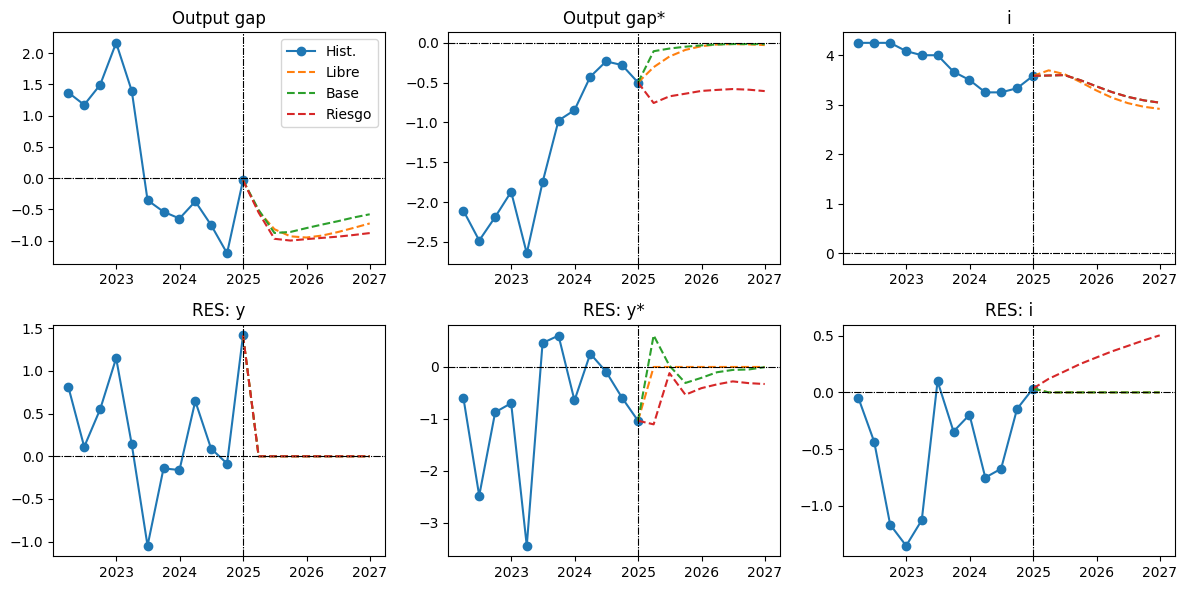

In [206]:
BDdict11 = {'Libre': FDB,'Base': UFDB_base, 'Riesgo': UFDB_riesgo11}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

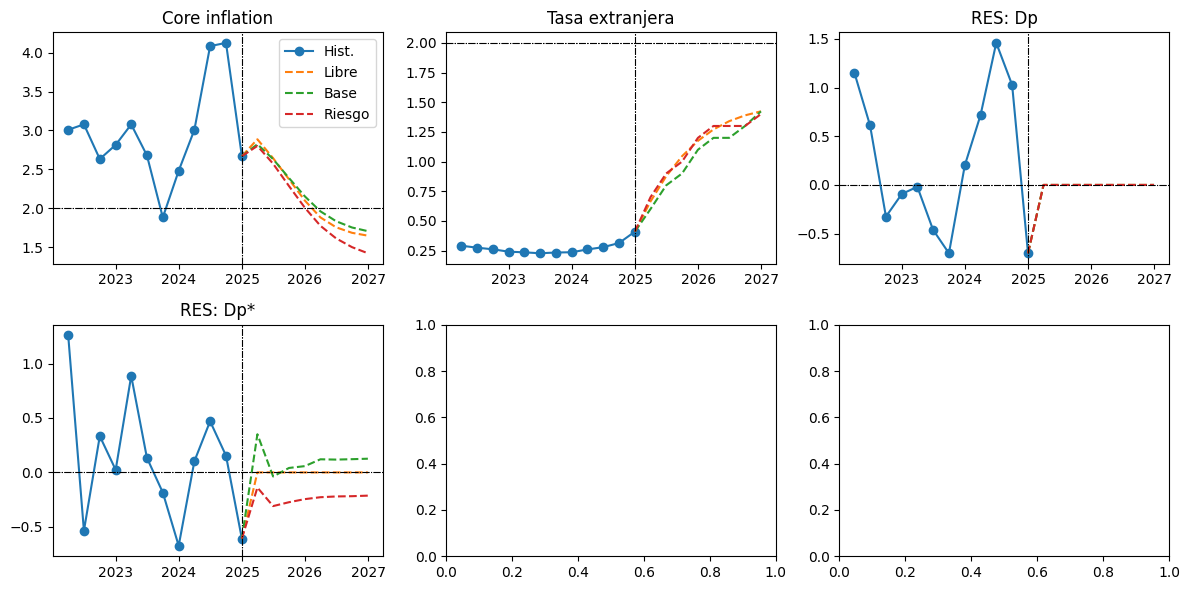

In [207]:
lista = ['Dpsae','iext','res_Dpsae','res_Dps']
listanames = ['Core inflation','Tasa extranjera','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

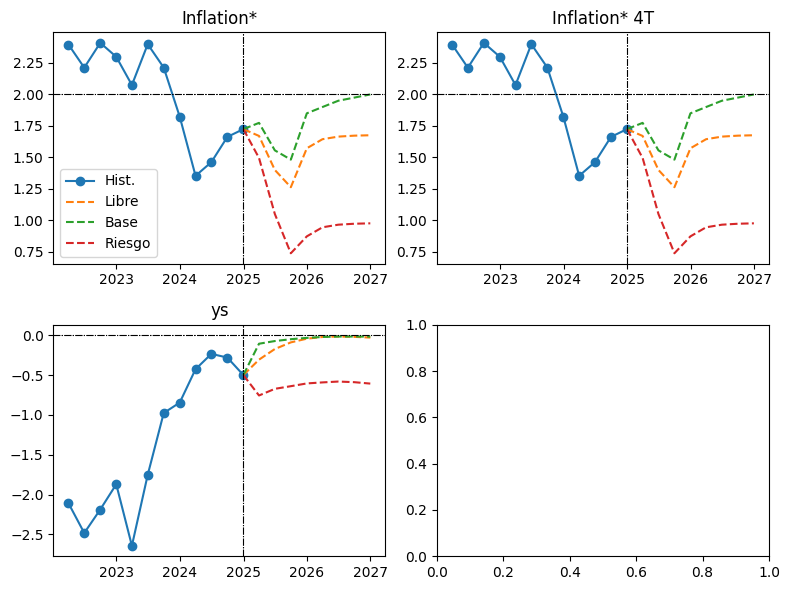

In [208]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,2,2)

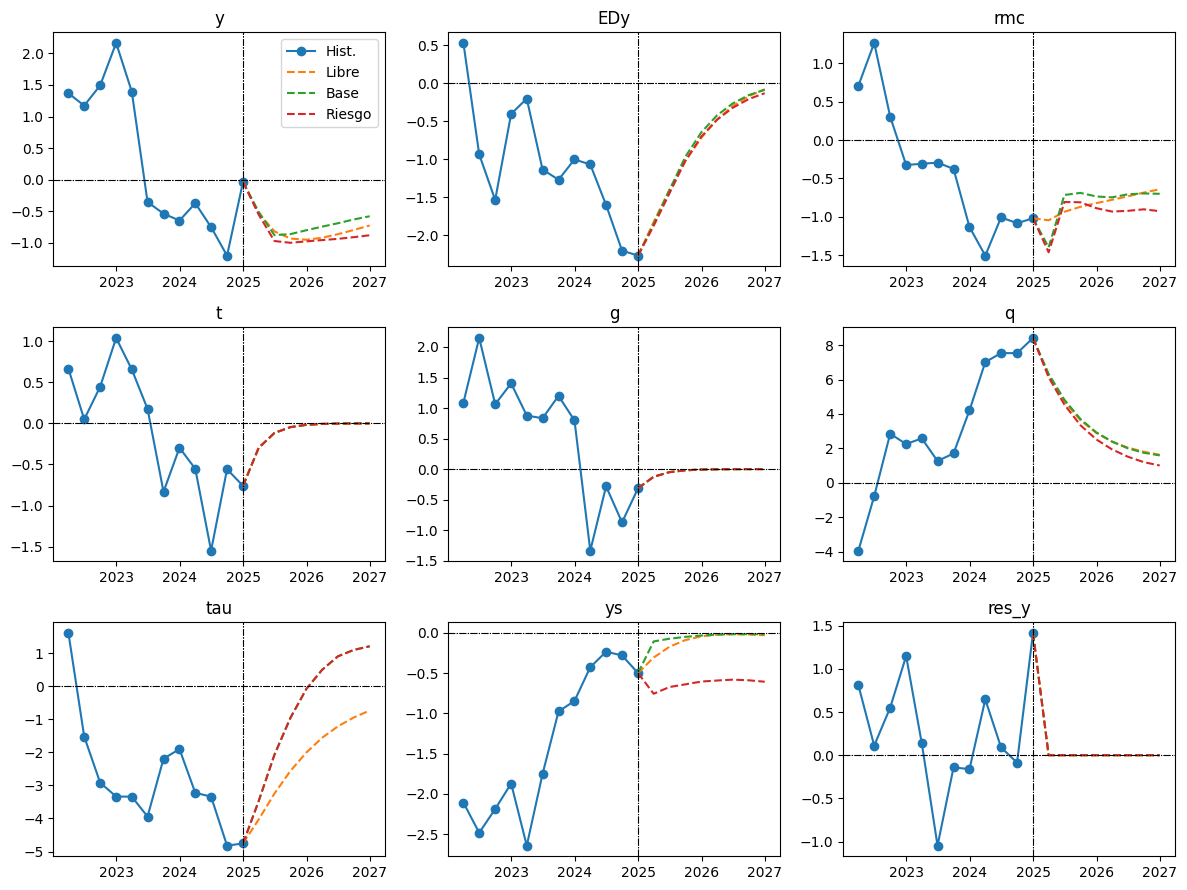

In [209]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict11,lista,listanames,listaSS,FH,HH,3,3)

In [210]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo11['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo11['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo11['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo11['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo11['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo11['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo11['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo11['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo11['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo11['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_riesgo6.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.551654   -0.970500   -0.998470   -0.975770   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.368064   -0.647517   -0.666179   
Confianza: aEy*EDy         -0.239445   -0.184779   -0.129728   -0.089247   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.438186   -0.241916   -0.242970   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.142360    0.105353    0.077670    0.058474   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.041608   -0.037002   -0.035168   -0.033258   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.955924   -0.936186   -0.909315   -0.878826  
Inercia: (ay+aEy)*y(-1)    -0.651034   -0.637793   -0.624624   -0.606695  
Confianza: aEy*EDy         -0.061000   -0.040784   -0.026174   -0.016327  
Cond. Mon.: armc*rmc(-1)   -0.266100   -0.279157   -0.276401   -0.270441  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.045097    0.035241    0.027930    0.023350  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.032554   -0.031959   -0.032400   -0.033375  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000